In [2]:
####################################################################################################################
####################################################################################################################
#PRE-PROCESSING
####################################################################################################################
####################################################################################################################



#Import pacakges
from datetime import datetime
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import gc
import highspy
from pyomo.common.timing import TicTocTimer
import os
from pathlib import Path
from definitions import PROJECT_ROOT
data_root = Path(PROJECT_ROOT, 'src/models')

if str(os.getcwd()) != "src\\models\\hydrogen\\regionality and hubs":
    os.chdir(".\\scripts")


import sympy as sp
import statsmodels.api as sm

#import scripts
import preprocessor_simple as prep
import regions
#import postprocessor as post

import time


####################################################################################################################


ModuleNotFoundError: No module named 'definitions'

In [ ]:
##############################################################################################################
### ELECTRICITY MODULE
##############################################################################################################

import numpy as np
import re
from itertools import product
import os

def ECMModel_price_load(all_frames, setA, H2Price, H2PriceSet, Load, LoadSet, sense=pyo.minimize, as_block=False):
    """ Create a block structure for restore electricity model

    Args:
        all_frames (data frame) : preprocessed data
        setA (data frame) :  preprocessed data
        H2Price (mutable parameter) : mutable parameter declared at parent level
        H2PriceSet (set) : index set which defines H2Price
        Load (mutable parameter) : mutable parameter declared at parent level
        LoadSet (set) : index set which defines Load
        ***** All other parameters, variables, and dataframes are created within this function.
        ***** Review electricity model documentation for more information

    Returns:
        model (Pyomo ConcreteModel) : the instantiated model or block
    """
    
    ##################################################################################################################################################################
    ##################################################################################################################################################################
    ##################################################################################################################################################################
    
    ## ADD TO CREATE BLOCKS

    if as_block:
        self = pyo.Block() 
    else:
        self = pyo.ConcreteModel(name='ElectricityModel')

    ##################################################################################################################################################################
    ##################################################################################################################################################################
    ##################################################################################################################################################################

    #self.dual = Suffix(direction=Suffix.IMPORT)

        

        ####################################################################################################################
        #Switches
        # TODO: figure out why certain year/region combos are unbounded
        # TODO: add test_region and years to scedes file
        
    self.sw_trade =     setA.sw_trade
    self.sw_expansion = setA.sw_expansion
    self.sw_agg_years = setA.sw_agg_years
    self.sw_rm =        setA.sw_rm
    self.sw_ramp =      setA.sw_ramp
    self.sw_reserves =  setA.sw_reserves
    self.sw_learning =  setA.sw_learning
    self.sw_h2int = 0
        
        ####################################################################################################################
        #Sets

    self.hr = pyo.Set(initialize = setA.hr) #change hours (1-48) or (1-577)?
    self.day = pyo.Set(initialize = setA.day)
    self.y = pyo.Set(initialize = setA.y)
    self.s = pyo.Set(initialize = setA.s)

    self.r = pyo.Set(initialize = range(1,26))
    self.r_can = pyo.Set(initialize = range(29,34))

    self.SupplyPriceSet = pyo.Set(initialize = all_frames['SupplyPrice'].index)
    self.SupplyCurveSet = pyo.Set(initialize = all_frames['SupplyCurve'].index)

    #Create sparse sets 
    def create_subsets(df,col,subset):
        df = df[df[col].isin(subset)].dropna()
        return df

    def create_hourly_sets(df):
        df = pd.merge(df,
                    all_frames['Map_hr_s'].reset_index(),
                    on=['s'], how='left').drop(columns=['s'])
        return df

    index_list = ['pt','y','r','steps','hr'] 

    self.GenSet = pyo.Set(
        initialize = create_hourly_sets(
            create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.ptg))
        .set_index(index_list).index
        )
    
    self.ptd_upper_set = pyo.Set(
        initialize = create_hourly_sets(
            create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.ptd))
        .set_index(index_list).index
        )
    
    self.pth_upper_set = pyo.Set(
        initialize = create_hourly_sets(
            create_subsets(
                create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.pth),
                'steps',[2]))
        .set_index(index_list).index
        )
    
    self.Gen_ramp_set = pyo.Set(
        initialize = create_subsets(
            create_hourly_sets(
                create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.ptc)),
                'hr',setA.hr23)
        .set_index(index_list).index
        )
    
    self.FirstHour_gen_ramp_set = pyo.Set(
        initialize = create_subsets(
            create_hourly_sets(
                create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.ptc)),
                'hr',setA.hr1)
        .set_index(index_list).index
        )
    
    self.HydroSet = pyo.Set(initialize = all_frames['HydroCapFactor'].index)
    self.IdaytqSet = pyo.Set(initialize = all_frames['Idaytq'].index)
    #self.LoadSet = pyo.Set(initialize = all_frames['Load'].index)

    self.StorageSet = pyo.Set(
        initialize = create_hourly_sets(
            create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.pts))
        .set_index(index_list).index
        )
            
    self.H2GenSet = pyo.Set(
        initialize = create_hourly_sets(
            create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.pth2))
        .set_index(index_list).index
        )
    
    self.UnmetSet = self.r * self.y * self.hr
    self.HydroMonthsSet = pyo.Set(
        initialize = create_subsets(
            create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.pth),'steps',[1]
            ).drop(columns=['steps']).set_index(['pt','y','r','s']).index
        )
    
    #TODO: move ptd to pt set list

    self.StorageBalance_set = pyo.Set(
        initialize = create_subsets(
            create_hourly_sets(
                create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.pts)),
                'hr',setA.hr23)
        .set_index(index_list).index
        )

    self.FirstHourStorageBalance_set = pyo.Set(
        initialize = create_subsets(
            create_hourly_sets(
                create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.pts)),
                'hr',setA.hr1)
        .set_index(index_list).index
        )

    self.ptiUpperSet = pyo.Set(initialize = all_frames['ptiUpperSet'].index)        
    #self.H2PriceSet = pyo.Set(initialize = all_frames['H2Price'].index)

    def capacitycredit_df():
        df = create_hourly_sets(all_frames['SupplyCurve'].reset_index())
        df = pd.merge(df,all_frames['ptiUpperSet'].reset_index(),how='left',on=index_list
                        ).rename(columns={'SolWindCapFactor':'CapacityCredit'})
        df['CapacityCredit'] = df['CapacityCredit'].fillna(1)
        df2 = pd.merge(all_frames['HydroCapFactor'].reset_index(),all_frames['Map_hr_d'].reset_index(),
                    on=['day'], how='left').drop(columns=['day'])
        df2['pt'] = setA.pth[0]
        df = pd.merge(df,df2,how='left',on=['pt','r','hr'])
        df.loc[df['pt'].isin(setA.pth),'CapacityCredit'] = df['HydroCapFactor']
        df = df.drop(columns=['SupplyCurve','HydroCapFactor']).set_index(index_list)
        return df

    if self.sw_expansion:
        if self.sw_learning > 0:
            self.LearningRateSet = pyo.Set(initialize = all_frames['LearningRate'].index)
            self.CapCost0Set = pyo.Set(initialize = all_frames['CapCost_y0'].index)
            self.LearningPtSet = pyo.Set(initialize = all_frames['SupplyCurve_learning'].index)
        self.CapCostSet = pyo.Set(initialize = all_frames['CapCost'].index)
        self.FOMCostSet = pyo.Set(initialize=all_frames['FOMCost'].index)
        self.allowBuildsSet = pyo.Set(initialize=all_frames['allowBuilds'].index)
        self.RetSet = pyo.Set(initialize=all_frames['RetSet'].index)
        self.CapacityCreditSet = pyo.Set(initialize=capacitycredit_df().index)

    if self.sw_trade:
        self.TranCostSet = pyo.Set(initialize = all_frames['TranCost'].index)
        self.TranLimitSet = pyo.Set(initialize = all_frames['TranLimit'].index)
        self.TradeSet = pyo.Set(
            initialize = create_hourly_sets(
                all_frames['TranLimit'].reset_index()
                ).set_index(['r', 'r1', 'y', 'hr']).index
            )
        
        self.TranCostCanSet = pyo.Set(initialize=all_frames['TranCostCan'].index)
        self.TranLimitCanSet = pyo.Set(initialize = all_frames['TranLimitCan'].index)
        self.TranLineLimitCanSet = pyo.Set(initialize = all_frames['TranLineLimitCan'].index)
        self.TradeCanSet = pyo.Set(
            initialize = pd.merge(
                all_frames['TranLimitCan'].reset_index(), all_frames['TranLineLimitCan'].reset_index(), how="inner"
                ).drop(columns=['TranLimitCan']).set_index(['r', 'r1', 'y','CSteps', 'hr']).index
            )

    if self.sw_ramp:
        self.RampUp_CostSet = pyo.Set(initialize=all_frames['RampUp_Cost'].index)
        self.RampRateSet = pyo.Set(initialize=all_frames['RampRate'].index)

        self.RampSet = pyo.Set(
            initialize = create_hourly_sets(
                create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setA.ptc))
            .set_index(index_list).index
            )        

    if self.sw_reserves:
        self.ProcurementSet = pyo.Set(initialize=
            pd.merge(create_hourly_sets(all_frames['SupplyCurve'].reset_index()),
                        pd.DataFrame({'restypes': setA.restypes}),
                        how='cross').set_index(['restypes']+index_list).index
        )
        
        self.RegReservesCostSet = pyo.Set(initialize=all_frames['RegReservesCost'].index)
        self.ResTechUpperBoundSet = pyo.Set(initialize=all_frames['ResTechUpperBound'].index)

    ####################################################################################################################
    #Parameters

    self.Storagelvl_cost = pyo.Param(initialize=0.00000001)
    self.UnmetLoad_penalty = pyo.Param(initialize=500)
    self.Idaytq = pyo.Param(self.IdaytqSet, initialize = all_frames['Idaytq'], default = 0)
    #self.Load = pyo.Param(self.LoadSet, initialize = all_frames['Load'], default = 0)
    self.HydroCapFactor = pyo.Param(self.HydroSet, initialize = all_frames['HydroCapFactor'], default = 0)
    
    self.BatteryChargeCap = pyo.Param(
        self.StorageSet, 
        initialize = create_hourly_sets(
            create_subsets(
                all_frames['SupplyCurve'].reset_index(),'pt',setA.pts
                )
            ).set_index(index_list), 
        default = 0
        )
    
    self.BatteryEfficiency = pyo.Param(setA.pts, initialize = all_frames['BatteryEfficiency'], default = 0)
    self.HourstoBuy= pyo.Param(setA.pts, initialize = all_frames['HourstoBuy'], default = 0)
    self.Dayweights = pyo.Param(self.hr, initialize = all_frames['Dayweights'], default = 0)
    self.SupplyPrice = pyo.Param(self.SupplyPriceSet, initialize = all_frames['SupplyPrice'], default = 0)
    self.SupplyCurve = pyo.Param(self.SupplyCurveSet, initialize = all_frames['SupplyCurve'], default = 0)
    self.SolWindCapFactor = pyo.Param(self.ptiUpperSet, initialize=all_frames['ptiUpperSet'], default = 0) 
    
    #comment out mutable for h2 price
    #self.H2Price = pyo.Param(self.H2PriceSet, initialize=all_frames['H2Price'], default = 0) #eventually connect with H2 model
    #self.H2PriceSet = pyo.Set(initialize = all_frames['H2Price'].index)
    
    self.year_weights = pyo.Param(self.y, initialize = all_frames['year_weights'], default = 0)
    self.Map_hr_s = pyo.Param(self.hr, initialize = all_frames['Map_hr_s'], default = 0) #all_frames['Map_hr_s'].loc[hr]['s']
    self.Hr_weights = pyo.Param(self.hr, initialize=all_frames['Hr_weights']['Hr_weights'], default=0) #all_frames['Hr_weights']['Hr_weights'][hr]
    self.Map_hr_d = pyo.Param(self.hr, initialize = all_frames['Map_hr_d']['day'], default=0)

    if self.sw_expansion:
        # if learning is not to be solved nonlinearly directly in the obj
        if self.sw_learning < 2:
            if self.sw_learning == 0:
                mute = False
            else:
                mute = True
            self.capacity_costs_learning = pyo.Param(self.CapCostSet, initialize = all_frames['CapCost'], default = 0, mutable=mute)
        # if learning is non-linear
        if self.sw_learning > 0:
            self.LearningRate = pyo.Param(self.LearningRateSet, initialize = all_frames['LearningRate'], default = 0)
            self.CapCost_y0 = pyo.Param(self.CapCost0Set, initialize = all_frames['CapCost_y0'], default = 0)
            self.SupplyCurve_learning = pyo.Param(self.LearningPtSet, initialize = all_frames['SupplyCurve_learning'], default = 0)
        
        self.FOMCost = pyo.Param(self.FOMCostSet, initialize=all_frames['FOMCost'], default=0)
        self.CapacityCredit = pyo.Param(self.CapacityCreditSet, initialize=capacitycredit_df(), default=0)

    if self.sw_trade:
        self.TranCost = pyo.Param(self.TranCostSet, initialize = all_frames['TranCost'], default = 0)
        self.TranLimit = pyo.Param(self.TranLimitSet, initialize = all_frames['TranLimit'], default = 0)

        self.TranCostCan = pyo.Param(self.TranCostCanSet, initialize=all_frames['TranCostCan'], default=0)
        self.TranLimitCan = pyo.Param(self.TranLimitCanSet, initialize=all_frames['TranLimitCan'], default=0)
        self.TranLineLimitCan = pyo.Param(self.TranLineLimitCanSet, initialize = all_frames['TranLineLimitCan'], default = 0)
    
    if self.sw_rm:
        self.ReserveMargin = pyo.Param(self.r, initialize=all_frames['ReserveMargin'], default=0)
        
    if self.sw_ramp:
        self.RampUp_Cost = pyo.Param(self.RampUp_CostSet, initialize=all_frames['RampUp_Cost'], default=0)
        self.RampDown_Cost = pyo.Param(self.RampUp_CostSet, initialize=all_frames['RampDown_Cost'], default=0)
        self.RampRate = pyo.Param(self.RampRateSet, initialize=all_frames['RampRate'], default=0)

    if self.sw_reserves:
        self.RegReservesCost = pyo.Param(self.RegReservesCostSet, initialize=all_frames['RegReservesCost'], default=0)
        self.ResTechUpperBound = pyo.Param(self.ResTechUpperBoundSet, initialize=all_frames['ResTechUpperBound'], default=0)
    
    

    ####################################################################################################################
    #Upper Bounds

    if self.sw_trade:
        def Trade_upper(self, r, r1, y, hr):
            return (0, self.TranLimit[(r, r1,
                                        self.Map_hr_s[hr], y)] * self.Hr_weights[hr])

    ####################################################################################################################
    #Variables

    self.Storage_inflow = pyo.Var(self.StorageSet, within=pyo.NonNegativeReals) #Storage inflow in hour h #GW
    self.Storage_outflow = pyo.Var(self.StorageSet, within=pyo.NonNegativeReals) #Storage outflow in hour h #GW
    self.Storage_level = pyo.Var(self.StorageSet, within=pyo.NonNegativeReals) #storage energy level in hour h #GWh
    self.Generation = pyo.Var(self.GenSet, within=pyo.NonNegativeReals) #Operated capacity GW use of technology group T in hour h #GW
    self.unmet_Load = pyo.Var(self.UnmetSet, within=pyo.NonNegativeReals) #slack variable #GW

    self.TotalCapacity = pyo.Var(self.SupplyCurveSet, within=pyo.NonNegativeReals) #Total capacity (existing + new - retirements) #GW

    if self.sw_expansion:
        self.CapacityBuilds = pyo.Var(self.CapCostSet, within=pyo.NonNegativeReals) #GW
        self.CapacityRetirements = pyo.Var(self.RetSet, within=pyo.NonNegativeReals) #GW

    if self.sw_trade:
        self.TradeToFrom = pyo.Var(self.TradeSet, within=pyo.NonNegativeReals, bounds = Trade_upper) # Trade to region r from r1 #GW
        self.TradeToFromCan = pyo.Var(self.TradeCanSet, within=pyo.NonNegativeReals) # Trade to region r from r1 with canada #GW

    if self.sw_rm:
        self.AvailStorCap = pyo.Var(self.StorageSet, within=pyo.NonNegativeReals) #Available storage capacity #GW
        
    if self.sw_ramp:
        self.RampUp = pyo.Var(self.RampSet, within=pyo.NonNegativeReals)
        self.RampDown = pyo.Var(self.RampSet, within=pyo.NonNegativeReals)

    if self.sw_reserves:
        self.ReservesProcurement = pyo.Var(self.ProcurementSet, within=pyo.NonNegativeReals)
        

    ####################################################################################################################
    #Objective Function
    self.StorageSetByHour = pyo.Set(self.hr)
    self.GenSetByHour = pyo.Set(self.hr)
    #self.H2GenSetByHour = {}

    def populate_by_hour_sets_rule(m):
        for (tech, y, reg, step, hour) in m.StorageSet:
            m.StorageSetByHour[hour].add((tech, y, reg, step))
        for (tech, y, reg, step, hour) in m.GenSet:
            m.GenSetByHour[hour].add((tech, y, reg, step))
        #for (tech, y, reg, step, hour) in m.H2GenSet:
        #    if (hour) not in m.H2GenSetByHour:
        #        m.H2GenSetByHour[hour] = []  # TBD- collapse with default key value
        #    m.H2GenSetByHour[hour].append((tech, y, reg, step))
                
    self.populate_by_hour_sets = pyo.BuildAction(rule=populate_by_hour_sets_rule)

    #Variable Objectivefunction
    #make sure to correct all costs to multiply by year weights
    def dispatchCost(self):
        return sum(self.Dayweights[hr] * (
                    sum(self.year_weights[y] * (0.5 * self.SupplyPrice[(reg,s,tech,step,y)] \
                        * (self.Storage_inflow[(tech,y,reg,step,hr)] + self.Storage_outflow[(tech,y,reg,step,hr)]) \
                        + (self.Hr_weights[hr] * self.Storagelvl_cost) \
                        * self.Storage_level[(tech,y,reg,step,hr)]) \
                        for (tech, y, reg, step) in self.StorageSetByHour[hr]) \
                    + sum(self.year_weights[y] * self.SupplyPrice[(reg,s,tech,step,y)]
                                                    * self.Generation[(tech, y, reg, step, hr)] \
                            for (tech, y, reg, step) in self.GenSetByHour[hr]) \
            ) for hr in self.hr if (s := self.Map_hr_s[hr])) \
                + sum(self.Dayweights[hr] * 
                        self.year_weights[y] * H2Price[reg,s,tech,step,y] * setA.H2_heatrate \
                        * self.Generation[(tech, y, reg, 1, hr)] \
                    for (tech, y, reg, step, hr) in self.H2GenSet if (s := self.Map_hr_s[hr]))
    self.dispatchCost = pyo.Expression(expr=dispatchCost)

    def unmetLoadCost(self):
        return sum(self.Dayweights[hour] *
                    self.year_weights[y] * self.unmet_Load[(reg, y, hour)] * self.UnmetLoad_penalty \
                        for (reg, y, hour) in self.UnmetSet)
    self.unmetLoadCost = pyo.Expression(expr=unmetLoadCost)

    if self.sw_trade:
        def tradeCost(self):
            return sum(self.Dayweights[hour] * self.year_weights[y] * self.TradeToFrom[(reg,reg1,y,hour)] * self.TranCost[(reg,reg1,y)] \
                                for (reg,reg1,y,hour) in self.TradeSet) \
                        + sum(self.Dayweights[hour] * self.year_weights[y] * self.TradeToFromCan[(reg, reg_can, y, CSteps, hour)] * self.TranCostCan[(reg, reg_can, CSteps, y)] \
                                for(reg, reg_can, y, CSteps, hour) in self.TradeCanSet)
        self.tradeCost = pyo.Expression(expr=tradeCost)


    if self.sw_ramp: #ramping
        def RampCost(self):
            return sum(self.Dayweights[hour] * self.year_weights[y] * (self.RampUp[(ptc, y, reg, step, hour)] * self.RampUp_Cost[ptc]
                        + self.RampDown[(ptc, y, reg, step, hour)] * self.RampDown_Cost[ptc]) \
                        for (ptc, y, reg, step, hour) in self.RampSet)
        self.RampCost = pyo.Expression(expr=RampCost)

    if self.sw_expansion:
        
        # nonlinear expansion costs
        if self.sw_learning == 2:
            
            def capExpansionCost(self): #TODO: not sure if I need self.year_weights[y] weighting here, I don't think so but maybe?
                return sum((self.CapCost_y0[(reg, pt, step)] \
            * (((self.SupplyCurve_learning[pt]  \
                + 0.0001*(y - setA.start_year)
                + sum(sum(self.CapacityBuilds[(r, pt, year, steps)] for year in setA.y if year < y) 
                    for (r, tech, steps) in self.CapCost0Set if tech == pt)) \
                / self.SupplyCurve_learning[pt]) \
            ** (-1.0*self.LearningRate[pt])) )
                * self.CapacityBuilds[(reg,pt,y,step)] \
                            for (reg,pt,y,step) in self.CapCostSet)
            self.capExpansionCost = pyo.Expression(expr=capExpansionCost)
        else: #linear expansion costs
        
            def capExpansionCost(self): #TODO: not sure if I need self.year_weights[y] weighting here, I don't think so but maybe?
                return sum(self.capacity_costs_learning[(reg,pt,y,step)] * self.CapacityBuilds[(reg,pt,y,step)] \
                            for (reg,pt,y,step) in self.CapCostSet)
            self.capExpansionCost = pyo.Expression(expr=capExpansionCost)

        # choosing summer for capacity, may want to revisit this assumption
        def FOMCostObj(self):
            return sum(self.year_weights[y] * self.FOMCost[(reg, pt, steps)] \
                        * self.TotalCapacity[(reg, s, pt, steps, y)]  \
                                for (reg,s,pt,steps,y) in self.SupplyCurveSet if s==2) #need to fix this weighting

        self.FOMCostObj = pyo.Expression(expr=FOMCostObj)

    if self.sw_reserves: # operating reserves
        def opresCost(self):
            return sum( (self.RegReservesCost[pt] if restype == 2 else 0.01)
                        * self.Dayweights[hr] * self.year_weights[y] \
                        * self.ReservesProcurement[(restype, pt, y, r, steps, hr)] \
                                for (restype, pt, y, r, steps, hr) in self.ProcurementSet)
        self.opresCost = pyo.Expression(expr=opresCost)

    def objFunction(self):
        return (self.dispatchCost + self.unmetLoadCost
                + (self.RampCost if self.sw_ramp else 0)
                + (self.tradeCost if self.sw_trade else 0)
                + (self.capExpansionCost + self.FOMCostObj if self.sw_expansion else 0)
                + (self.opresCost if self.sw_reserves else 0)
                )
            
    self.totalCost = pyo.Objective(rule=objFunction, sense = pyo.minimize)

    ####################################################################################################################
    #Constraints

    self.GenSetDemandBalance = {}
    self.StorageSetDemandBalance = {}
    self.TradeSetDemandBalance = {}
    self.TradeCanSetDemandBalance = {}
    def populate_demand_balance_sets_rule(m):
        for (tech, year, reg, step, hour) in m.GenSet:
            if (year, reg, hour) not in m.GenSetDemandBalance:
                m.GenSetDemandBalance[(year, reg, hour)] = []  # TBD- collapse with default key value
            m.GenSetDemandBalance[(year, reg, hour)].append((tech, step))
        for (tech, year, reg, step, hour) in m.BatteryChargeCap:
            if (year, reg, hour) not in m.StorageSetDemandBalance:
                m.StorageSetDemandBalance[(year, reg, hour)] = []
            m.StorageSetDemandBalance[(year, reg, hour)].append((tech, step))
        if m.sw_trade == 1:
            for (reg, reg1, year, hour) in m.TradeSet:
                if (year, reg, hour) not in m.TradeSetDemandBalance:
                    m.TradeSetDemandBalance[(year, reg, hour)] = []
                m.TradeSetDemandBalance[(year, reg, hour)].append(reg1)
            for (reg, reg1, year, CSteps, hour) in m.TradeCanSet:
                if (year, reg, hour) not in m.TradeCanSetDemandBalance:
                    m.TradeCanSetDemandBalance[(year, reg, hour)] = []
                m.TradeCanSetDemandBalance[(year, reg, hour)].append((reg1, CSteps))
    self.populate_demand_balance_sets = pyo.BuildAction(rule=populate_demand_balance_sets_rule)

    #Property: ShadowPrice
    @self.Constraint(LoadSet)
    def Demand_balance(self, r, y, hr):
        return Load[(r, y, hr)] <= \
                sum(self.Generation[(tech, y, r, step, hr)] for (tech, step) in self.GenSetDemandBalance[(y, r, hr)]) \
                + sum(self.Storage_outflow[(tech,y,r,step,hr)] - self.Storage_inflow[(tech,y,r,step,hr)] \
                    for (tech, step) in self.StorageSetDemandBalance[(y,r,hr)]) \
                + self.unmet_Load[(r, y, hr)] \
                + (sum(self.TradeToFrom[(r,reg1,y,hr)]*(1-setA.TransLoss) - self.TradeToFrom[(reg1,r,y,hr)] \
                    for (reg1) in self.TradeSetDemandBalance[(y, r, hr)]) if self.sw_trade else 0) \
                + (sum(self.TradeToFromCan[(r, r_can, y, CSteps, hr)] * (1 - setA.TransLoss) \
                    for (r_can, CSteps) in self.TradeCanSetDemandBalance[(y, r, hr)]) if (self.sw_trade == 1 and r in setA.r_can_conn) else 0)

    # #First hour
    @self.Constraint(self.FirstHourStorageBalance_set)
    def FirstHourStorageBalance(self, pts, y, r, steps, hr1):
        return self.Storage_level[(pts,y,r,steps,hr1)] == self.Storage_level[(pts,y,r,steps,hr1 + setA.num_hr_day-1)] \
            + self.BatteryEfficiency[pts] * self.Storage_inflow[(pts,y,r,steps,hr1)] - self.Storage_outflow[(pts,y,r,steps,hr1)]

    # #Not first hour
    @self.Constraint(self.StorageBalance_set)
    def StorageBalance(self, pts, y, r, steps, hr23):
        return self.Storage_level[(pts,y,r,steps,hr23)] == self.Storage_level[(pts,y,r,steps,hr23-1)] \
            + self.BatteryEfficiency[pts] * self.Storage_inflow[(pts,y,r,steps,hr23)] - self.Storage_outflow[(pts,y,r,steps,hr23)]

    self.DaySHydro = pyo.Set(self.s)
    self.HourSHydro = pyo.Set(self.s)

    def populate_hydro_sets_rule(m):
        for (s, hr) in all_frames['Map_hr_s'].reset_index().set_index(['s', 'hr']).index:
            m.HourSHydro[s].add(hr)
        for (s, day) in all_frames['Map_day_s'].reset_index().set_index(['s', 'day']).index:
            m.DaySHydro[s].add(day)

    self.populate_hydro_sets = pyo.BuildAction(rule=populate_hydro_sets_rule)

    @self.Constraint(self.HydroMonthsSet)
    def Hydro_Gen_Cap(self, pth, y, r, s):
        return sum(self.Generation[pth, y, r, 1, hr] * \
                self.Idaytq[self.Map_hr_d[hr]] \
                    for hr in self.HourSHydro[s]) \
            <= sum(self.TotalCapacity[(r, s, pth, 1, y)] \
                * self.HydroCapFactor[r, day] \
                * self.Idaytq[day] \
                for day in self.DaySHydro[s]) * 24 # leave as 24


    ####################################################################################################################
    #Constraints Generation Variable Upper Bounds

    @self.Constraint(self.ptd_upper_set)
    def ptd_upper(self, ptd, y, r, steps, hr):
        return (self.Generation[(ptd,y,r,steps,hr)]
                + (sum(self.ReservesProcurement[(restype, ptd, y, r, steps, hr)]
                        for restype in setA.restypes) if self.sw_reserves else 0) \
                <= \
                self.TotalCapacity[(r, self.Map_hr_s[hr], ptd, steps, y)] \
                * self.Hr_weights[hr])

    @self.Constraint(self.pth_upper_set)
    def pth_upper(self, pth, y, r, steps, hr):
        return ((self.Generation[(pth,y,r,steps,hr)] \
                    + sum(self.ReservesProcurement[(restype, pth, y, r, steps, hr)]
                            for restype in setA.restypes) if self.sw_reserves else 0) \
                <= \
                self.TotalCapacity[(r, self.Map_hr_s[hr], pth, steps, y)] \
                * self.HydroCapFactor[(r, self.Map_hr_d[hr])] \
                * self.Hr_weights[hr])

    @self.Constraint(self.ptiUpperSet)
    def pti_upper(self, pti, y, r, steps, hr):
        return (self.Generation[(pti,y,r,steps,hr)] \
                + (sum(self.ReservesProcurement[(restype, pti, y, r, steps, hr)]
                        for restype in setA.restypes) if self.sw_reserves else 0) \
                <= \
                self.TotalCapacity[(r, self.Map_hr_s[hr], pti, steps, y)] \
                * self.SolWindCapFactor[(pti,y,r,steps,hr)] \
                * self.Hr_weights[hr])

    @self.Constraint(self.StorageSet)
    def Storage_inflow_upper(self, pt, y, r, steps, hr):
        return (self.Storage_inflow[(pt,y,r,steps,hr)] \
                <= \
                self.TotalCapacity[(r, self.Map_hr_s[hr], pt, steps, y)] \
                    * self.Hr_weights[hr])

    # TODO check if it's only able to build in regions with existing capacity?
    @self.Constraint(self.StorageSet)
    def Storage_outflow_upper(self, pt, y, r, steps, hr):
        return (self.Storage_outflow[(pt,y,r,steps,hr)] \
                + (sum(self.ReservesProcurement[(restype, pt, y, r, steps, hr)] \
                        for restype in setA.restypes) if self.sw_reserves else 0) \
                <= \
                self.TotalCapacity[(r, self.Map_hr_s[hr], pt, steps, y)] \
                    * self.Hr_weights[hr])

    @self.Constraint(self.StorageSet)
    def Storage_level_upper(self, pt, y, r, steps, hr):
        return  self.Storage_level[(pt,y,r,steps,hr)] <= \
                    self.TotalCapacity[(r, self.Map_hr_s[hr], pt, steps, y)] \
                    * self.HourstoBuy[(pt)]

    @self.Constraint(self.SupplyCurveSet)
    def totalCapacityEq(self, r, s, pt, steps, y):
            return self.TotalCapacity[(r, s, pt, steps, y)] == \
                self.SupplyCurve[(r, s, pt, steps, y)] \
                    + (sum(self.CapacityBuilds[(r, pt, year, steps)] for year in setA.y if year <= y) \
                        if self.sw_expansion and (pt, steps) in self.allowBuildsSet else 0) \
                    - (sum(self.CapacityRetirements[(pt, year, r, steps)] for year in setA.y if year <= y) \
                        if self.sw_expansion and (pt, y, r, steps) in self.RetSet else 0)

    if self.sw_expansion:
        @self.Constraint(self.RetSet)
        def Ret_upper(self, pt, y, r, steps):
            return self.CapacityRetirements[(pt, y, r, steps)] <= \
                ((self.SupplyCurve[(r, 2, pt, steps, y)] if (r, 2, pt, steps, y) in self.SupplyCurveSet else 0) \
                    + (sum(self.CapacityBuilds[(r, pt, year, steps)] for year in setA.y if year < y) \
                        if (pt, steps) in self.allowBuildsSet else 0) \
                    - sum(self.CapacityRetirements[(pt, year, r, steps)] for year in setA.y if year < y) \
                    )
                    

    ### trade upper bound

    if self.sw_trade and all_frames['TranLineLimitCan'].size != 0:
        # run time seems worth it to create trade sets rule if there are , adds 9 sec (29 to 23 sec) build time if trade on with all regions

        # this may have made it run slightly slower with only 3 regions
        self.TradeCanSetUpper = {}
        self.TradeCanLineSetUpper = {}
        def populate_trade_sets_rule(m):
            for (reg, reg1, year, CSteps, hour) in m.TradeCanSet:
                if (reg, reg1, year, hour) not in m.TradeCanLineSetUpper:
                    m.TradeCanLineSetUpper[(reg, reg1, year, hour)] = []
                m.TradeCanLineSetUpper[(reg, reg1, year, hour)].append((CSteps))
                if (reg1, year, CSteps, hour) not in m.TradeCanSetUpper:
                    m.TradeCanSetUpper[(reg1, year, CSteps, hour)] = []
                m.TradeCanSetUpper[(reg1, year, CSteps, hour)].append((reg))

        self.populate_trade_sets = pyo.BuildAction(rule=populate_trade_sets_rule)

        @self.Constraint(self.TranLineLimitCanSet)
        def tradelinecan_upper(self, r, r_can, y, hr):
            return (sum(self.TradeToFromCan[(r, r_can, y, c, hr)] for c in self.TradeCanLineSetUpper[(r, r_can, y, hr)]) \
                    <= \
                self.TranLineLimitCan[(r, r_can, y, hr)] * self.Hr_weights[hr])

        @self.Constraint(self.TranLimitCanSet)
        def tradecan_upper(self, r_can, CSteps, y, hr):
            return (sum(self.TradeToFromCan[(r,r_can,y,CSteps,hr)] for r in self.TradeCanSetUpper[(r_can, y, CSteps, hr)]) \
                    <= \
                self.TranLimitCan[(r_can, CSteps,y, hr)] * self.Hr_weights[hr])

    if self.sw_expansion and self.sw_rm:
        # must meet reserve margin requirement
        # apply to every hour, a fraction above the final year's load
        # ReserveMarginReq <= sum(Max capacity in that hour)

        self.SupplyCurveRM = {}

        def populate_RM_sets_rule(m):
            for (reg,s,tech,step,year) in m.SupplyCurveSet:
                if (year, reg, s) not in m.SupplyCurveRM:
                    m.SupplyCurveRM[(year, reg, s)] = []  # TBD- collapse with default key value
                m.SupplyCurveRM[(year, reg, s)].append((tech, step))

        self.populate_RM_sets = pyo.BuildAction(rule=populate_RM_sets_rule)

        @self.Constraint(LoadSet)
        def ReserveMarginLower(self, r, y, hr):
            return (Load[(r, y, hr)] * (1 + self.ReserveMargin[r]) \
                        <= \
                        self.Hr_weights[hr] \
                        * sum(
                            (self.CapacityCredit[(pt,y,r,steps,hr)] \
                            * (self.AvailStorCap[(pt, y, r, steps, hr)] if pt in setA.pts
                                else self.TotalCapacity[(r, self.Map_hr_s[hr], pt, steps, y)]) ) \
                            for (pt, steps) in self.SupplyCurveRM[(y, r, self.Map_hr_s[hr])]))
        
        # ensure available capacity to meet RM for storage < power capacity
        @self.Constraint(self.StorageSet)
        def AvailCapStor1_Upper(self, pts, y, r, steps, hr):
            return self.AvailStorCap[(pts, y, r, steps, hr)] <= \
                self.TotalCapacity[(r, self.Map_hr_s[hr], pts, steps, y)]
        
        # ensure available capacity to meet RM for storage < existing SOC
        @self.Constraint(self.StorageSet)
        def AvailCapStor2_Upper(self, pts, y, r, steps, hr):
            return self.AvailStorCap[(pts, y, r, steps, hr)] <= \
                self.Storage_level[(pts,y,r,steps,hr)]   

    if self.sw_ramp:
        #First hour
        @self.Constraint(self.FirstHour_gen_ramp_set)
        def FirstHour_gen_ramp(self, ptc, y, r, steps, hr1):
            return (self.Generation[(ptc,y,r,steps,hr1)] \
                == self.Generation[(ptc,y,r,steps,hr1 + setA.num_hr_day-1)]
                    + self.RampUp[(ptc,y,r,steps,hr1)]
                    - self.RampDown[(ptc,y,r,steps,hr1)])

        # NOT first hour
        @self.Constraint(self.Gen_ramp_set)
        def Gen_ramp(self, ptc, y, r, steps, hr23):
            return (self.Generation[(ptc, y, r, steps, hr23)] \
                == self.Generation[(ptc, y, r, steps, hr23 - 1)]
                    + self.RampUp[(ptc, y, r, steps, hr23)] - \
                    self.RampDown[(ptc, y, r, steps, hr23)])

        @self.Constraint(self.RampSet)
        def RampUp_upper(self, ptc, y, r, steps, hr):
            return self.RampUp[(ptc, y, r, steps, hr)] <= \
                self.Hr_weights[hr] * self.RampRate[ptc] \
                * self.TotalCapacity[(r, self.Map_hr_s[hr], ptc, steps, y)]


        @self.Constraint(self.RampSet)
        def RampDown_upper(self, ptc, y, r, steps, hr):
            return self.RampDown[(ptc, y, r, steps, hr)] <= \
                self.Hr_weights[hr] * self.RampRate[ptc] \
                * self.TotalCapacity[(r, self.Map_hr_s[hr], ptc, steps, y)]

    if self.sw_reserves:

        self.ProcurementSetReserves = {}
        #wind set
        self.WindSetReserves = {}
        #solar set
        self.SolarSetReserves = {}
        def populate_reserves_sets_rule(m):
            for (restype, pt, year, reg, step, hour) in m.ProcurementSet:
                if (restype, reg, year, hour) not in m.ProcurementSetReserves:
                    m.ProcurementSetReserves[(restype, reg, year, hour)] = []
                m.ProcurementSetReserves[(restype, reg, year, hour)].append((pt, step))
            #
            for (pt, year, reg, step, hour) in m.ptiUpperSet:
                if (year, reg, hour) not in m.WindSetReserves:
                    m.WindSetReserves[(year, reg, hour)] = []
                if (year, reg, hour) not in m.SolarSetReserves:
                    m.SolarSetReserves[(year, reg, hour)] = []

                if pt in setA.ptw:
                    m.WindSetReserves[(year, reg, hour)].append((pt, step))
                elif pt in setA.ptsol:
                    m.SolarSetReserves[(year, reg, hour)].append((pt, step))

        self.populate_reserves_sets = pyo.BuildAction(rule=populate_reserves_sets_rule)

        # 3% of load
        @self.Constraint(LoadSet)
        def spinReservesRequirement(self, r, y, hr):
            return (sum(self.ReservesProcurement[(1, pt, y, r, step, hr)]
                        for (pt, step) in self.ProcurementSetReserves[(1, r, y, hr)])
                    >= 0.03 * Load[(r, y, hr)])

        # 1% of load + 0.5% of wind generation + 0.3% of solar capacity
        @self.Constraint(LoadSet)
        def regReservesRequirement(self, r, y, hr):
            return (sum(self.ReservesProcurement[(2, pt, y, r, step, hr)]
                        for (pt, step) in self.ProcurementSetReserves[(2, r, y, hr)]) \
                    >= 0.01 * Load[(r, y, hr)] \
                    + 0.005 * sum(self.Generation[(ptw,y,r,step,hr)] \
                                for (ptw, step) in self.WindSetReserves[(y, r, hr)]) \
                    + 0.003 * self.Hr_weights[hr]
                            * sum(self.TotalCapacity[(r, self.Map_hr_s[hr], ptsol, step, y)] \
                                for (ptsol, step) in self.SolarSetReserves[(y, r, hr)]))

        #  10% of wind generation + 4% of solar capacity
        @self.Constraint(LoadSet)
        def flexReservesRequirement(self, r, y, hr):
            return (sum(self.ReservesProcurement[(3, pt, y, r, step, hr)]
                        for (pt, step) in self.ProcurementSetReserves[(3, r, y, hr)])
                    >= \
                + 0.1 * sum(self.Generation[(ptw, y, r, step, hr)]
                            for (ptw, step) in self.WindSetReserves[(y, r, hr)]) \
                + 0.04 * self.Hr_weights[hr] \
                            * sum(self.TotalCapacity[(r, self.Map_hr_s[hr], ptsol, step, y)] \
                                    for (ptsol, step) in self.SolarSetReserves[(y, r, hr)]))

        @self.Constraint(self.ProcurementSet)
        def resProcurementUpper(self, restypes, pt, y, r, steps, hr):
            return self.ReservesProcurement[(restypes, pt, y, r, steps, hr)] <= \
                self.ResTechUpperBound[(restypes, pt)] * self.Hr_weights[hr] \
                * self.TotalCapacity[(r, self.Map_hr_s[hr], pt, steps, y)]
    ##################################################################################################################################################################
    ##################################################################################################################################################################
    ##################################################################################################################################################################

    ## ADD TO CREATE BLOCKS

    #deactivates objective function so we can create a new objective function with multiple blocks
    if as_block:
        self.totalCost.deactivate()
    
    return self

    ##################################################################################################################################################################
    ##################################################################################################################################################################
    ##################################################################################################################################################################



In [ ]:

##############################################################################################################
### RESIDENTIAL MODULE
##############################################################################################################

"""Sets up the sympy version of the residential module. This includes 
        the 3 updating indexes, the combined full equation, and the equation converted to a python lambda function.
        It also loads in the base values for Load if they haven't been established yet.

"""
class residentialModule:
    prices = {}
    loads = {}
    hr_map = pd.DataFrame()
    baseYear = int()
    

    def __init__(self, loadFile = ''):
        self.year = sp.Idx('year')
        self.reg = sp.Idx('region')
        self.fuel = sp.Idx('fuel')
        self.LastHYr, self.LastMYr, self.BaseYr = sp.symbols(('LastHYr','LastMYr','base'))

        self.income = sp.IndexedBase('Income')
        self.incomeIndex = sp.IndexedBase('IncomeIndex')
        self.i_elas = sp.IndexedBase('IncomeElasticity')
        self.i_lag = sp.IndexedBase('IncomeLagParameter')

        self.price = sp.IndexedBase('Price')
        self.priceIndex = sp.IndexedBase('PriceIndex')
        self.p_elas = sp.IndexedBase('PriceElasticity')
        self.p_lag = sp.IndexedBase('PriceLagParameter')
        
        self.trendGR = sp.IndexedBase('TrendGR')

        self.consumption = sp.IndexedBase('Consumption')

        self.incomeEQ = (self.incomeIndex[self.year-1,self.reg,self.fuel] ** self.i_lag[self.reg,self.fuel]) * (self.income[self.year,self.reg,self.fuel]/self.income[self.BaseYr,self.reg,self.fuel]) ** self.i_elas[self.reg,self.fuel]
        self.priceEQ = (self.priceIndex[self.year-1,self.reg,self.fuel] ** self.p_lag[self.reg,self.fuel]) * (self.price[self.year,self.reg,self.fuel]/self.price[self.BaseYr,self.reg,self.fuel]) ** self.p_elas[self.reg,self.fuel]
        self.growthEQ = 1 + ((self.year - self.LastHYr)/(self.LastMYr - self.LastHYr)) * (((1 + self.trendGR[self.reg,self.fuel]) ** (self.LastMYr - self.LastHYr)) - 1)

        self.QIndex = self.incomeEQ * self.priceEQ * self.growthEQ

        self.demand = self.consumption[self.BaseYr,self.reg,self.fuel] * self.QIndex

        self.lambdifiedDemand = sp.lambdify([self.incomeIndex[self.year-1,self.reg,self.fuel],
                                    self.i_lag[self.reg,self.fuel],
                                    self.income[self.year,self.reg,self.fuel],
                                    self.income[self.BaseYr,self.reg,self.fuel],
                                    self.i_elas[self.reg,self.fuel],
                                    self.priceIndex[self.year-1,self.reg,self.fuel],
                                    self.p_lag[self.reg,self.fuel],
                                    self.price[self.year,self.reg,self.fuel],
                                    self.price[self.BaseYr,self.reg,self.fuel],
                                    self.p_elas[self.reg,self.fuel],
                                    self.year,
                                    self.LastHYr,
                                    self.LastMYr,
                                    self.trendGR[self.reg,self.fuel],
                                    self.consumption[self.BaseYr,self.reg,self.fuel]],
                                    self.demand)
        
        if loadFile:
            self.loads['BaseLoads'] = pd.read_csv(loadFile).set_index(['r','y','hr'],drop=False)
        elif not self.loads:
            self.loads['BaseLoads'] = pd.read_csv(data_root/'electricity'/'input'/ 'Load.csv').set_index(['r','y','hr'],drop=False)
        
        if not self.baseYear:
            self.baseYear = self.loads['BaseLoads'].y.min()

        if self.hr_map.empty:
            self.hr_map = self.temporal_mapping()
        
        pass


    def temporal_mapping(self):
        """Create dataFrame to map different parameters and granularities

        Returns
        -------
        pandas DataFrame
            Maps betweeen hours, days, seasons, and other weighted hour types
        """
        path_to_inputs = PROJECT_ROOT / 'electricity/input'
        df1 = pd.read_csv(path_to_inputs / 'cw_s_day.csv')
        df4 = df1.groupby(by=['Map_day'],as_index=False).count()
        df4 = df4.rename(columns={'Index_day':'Dayweights'}).drop(columns=['Map_s'])
        df1 = pd.merge(df1,df4,how='left',on=['Map_day'])
    
        df2 = pd.read_csv(path_to_inputs / 'cw_hr.csv')
        df3 = df2.groupby(by=['Map_hr'],as_index=False).count()
        df3 = df3.rename(columns={'Index_hr':'Hr_weights'})
        df2 = pd.merge(df2,df3,how='left',on=['Map_hr'])
    
        df = pd.merge(df1,df2,how='cross')
        df['hr'] = df.index
        df['hr'] = df['hr'] + 1
        df['Map_hr'] = (df['Map_day'] - 1) * df['Map_hr'].max() + df['Map_hr']
        # df.to_csv(path_to_inputs / 'temporal_map.csv',index=False)
        df.set_index('hr',inplace=True, drop=False)
        return df

    #Sets up base values
    def set_base_values(self, p, load):
        self.prices['BasePrices'] = p
        self.loads['BaseLoads'] = load
        return

    def update_load(self, p, p_index):
        n = len(list(p)[0])
        if n == 3:
            newLoad = self.update_load_Dual(p, p_index)
        elif n == 5:
            newLoad = self.update_load_SupplyPrice(p, p_index)
        return newLoad

    def update_load_Dual(self, p, p_index):
        if 'BaseDualPrices' not in self.prices.keys():
            self.prices['BaseDualPrices'] = pd.read_excel(data_root/'residential'/'input'/'cem_elec_prices.xlsx').set_index(['r','y','hr'],drop=False)
        self.demandF = lambda price, load, year, basePrice = 1, p_elas = -0.10, baseYear = self.prices['BaseDualPrices'].y.min(), baseIncome = 1, income = 1, i_elas = 1, priceIndex = 1, incomeIndex = 1, p_lag = 1, i_lag = 1, trend = 0 : \
                self.lambdifiedDemand(incomeIndex, i_lag, income, baseIncome, i_elas, priceIndex, p_lag, price, basePrice, p_elas, year, baseYear, 2050, trend, load)
        newPrices = pd.DataFrame(p.extract_values().values(),index=p_index,columns=['newPrice']).reset_index(names=['r','y','hr'])
        newPrices = abs(newPrices)
        hours = newPrices.hr.unique()
        # hours = self.loads['BaseLoads'].hr.unique()
        n = len(hours)
        if n == 4:
            hourMap = {i:[] for i in hours}
            for h in range(1,len(self.hr_map)+1):
                hourMap[self.hr_map.loc[h,'Map_s']].append(h)
        elif n == 96:
            hourMap = {i:[] for i in hours}
            for h in range(1,len(self.hr_map)+1):
                hourMap[self.hr_map.loc[h,'Map_hr']].append(h)
                
        newLoad = self.loads['BaseLoads'].copy().reset_index(drop=True)
        newLoad = newLoad.merge(newPrices, how='right')
        newLoad['AvgBasePrice'] = newLoad.apply(lambda row: sum(self.prices['BaseDualPrices'].loc[(row.r,2023,hr),'Dual'] for hr in hourMap[row.hr])/(len(hourMap[row.hr])), axis=1)
        newLoad.newPrice.fillna(newLoad.AvgBasePrice,inplace=True)
        newLoad['Load'] = self.demandF(newLoad.newPrice, newLoad.Load, newLoad.y, newLoad.AvgBasePrice)
        newLoad.set_index(['r','y','hr'], drop=False, inplace=True)
        return newLoad

    def update_load_SupplyPrice(self, p, p_index):
        if 'BaseSupplyPrices' not in self.prices.keys():
            self.prices['BaseSupplyPrices'] = pd.read_csv(PROJECT_ROOT / 'electricity/input/cem_inputs/SupplyPrice.csv').rename(columns={'SupplyPrice':'basePrice'})
        self.demandF = lambda price, load, year, basePrice = 1, p_elas = -0.10, baseYear = self.prices['BaseSupplyPrices'].y.min(), baseIncome = 1, income = 1, i_elas = 1, priceIndex = 1, incomeIndex = 1, p_lag = 1, i_lag = 1, trend = 0 : \
                self.lambdifiedDemand(incomeIndex, i_lag, income, baseIncome, i_elas, priceIndex, p_lag, price, basePrice, p_elas, year, baseYear, 2050, trend, load)
        avgPrices = pd.DataFrame(p.extract_values().values(),index=p_index,columns=['newPrice']).reset_index(names=['r','s','pt','steps','y'])
        avgPrices = avgPrices.merge(self.prices['BaseSupplyPrices'],how='left',on=['r','s','pt','steps','y'])
        year = avgPrices.y.unique()

        avgPrices = avgPrices.groupby(['r','y','s']).mean().drop(columns=['pt','steps'])
        
        if len(self.loads['BaseLoads'].hr.unique()) == 96:
            hourMap = self.hr_map.groupby(['Map_hr']).first().Map_s
        elif len(self.loads['BaseLoads'].hr.unique()) == 4:
            hourMap = pd.Series([1,2,3,4],index=[1,2,3,4])
        
        newLoad = self.loads['BaseLoads'].copy()

        newLoad['Load'] = newLoad.apply(lambda row: self.demandF(avgPrices.loc[(row.r,row.y,hourMap[row.hr]),'newPrice'],row.Load,row.y,avgPrices.loc[(row.r,self.baseYear,hourMap[row.hr]),'basePrice']),axis=1)

        return newLoad


    def make_block(self, prices, pricesindex):
            
        # mod = pyo.ConcreteModel()
        mod= pyo.Block()

        mod.price_set = pyo.Set(initialize=pricesindex)
        # mod.load_set = pyo.Set(initialize=self.loads['BaseLoads'].index)
        
            #loadIndex.append((i[0],2023,i[2]))
        mod.base_load = pyo.Param(mod.price_set, initialize=self.loads['BaseLoads'].loc[pricesindex,'Load'], mutable=True)
        updated_load = self.update_load(prices,pricesindex)
        # print(updated_load)
        mod.Load = pyo.Var(mod.price_set, within=pyo.NonNegativeReals)

        @mod.Constraint(mod.price_set)
        def create_load(mod,r,y,hr):
            #print(updated_load.loc[(r,y,hr),'Load'])
            return mod.Load[r,y,hr] == updated_load.loc[(r,y,hr),'Load']
        
        return mod
        
        
    #This is a standalone pyomo model
    #The objective function doesn't have much meaning
    #The real purpose is to have the load parameter changed into a variable that gets updated by the new prices
    def make_pyomo_model(self, prices):
        loadIndex = []
        for i in prices.index:
            loadIndex.append((i[0],2023,i[2]))
        mod = pyo.ConcreteModel()

        mod.price_set = pyo.Set(initialize=prices.index)
        mod.load_set = pyo.Set(initialize=loadIndex)
        
        mod.prices = pyo.Param(mod.price_set, initialize=prices.Dual, mutable=True)
        mod.base_load = pyo.Param(mod.load_set, initialize=self.loads['BaseLoads'].loc[loadIndex,'Load'], mutable=True)
        updated_load = self.update_load(prices)

        mod.Load = pyo.Var(mod.price_set, within=pyo.NonNegativeReals)

        mod.obj = pyo.Objective(rule = sum(mod.Load[r,y,hr] for [r,y,hr] in mod.price_set))

        @mod.Constraint(mod.price_set)
        def create_new_load(mod,r,y,hr):
            return mod.Load[r,y,hr] == updated_load.loc[(r,y,hr)]
        
        return mod


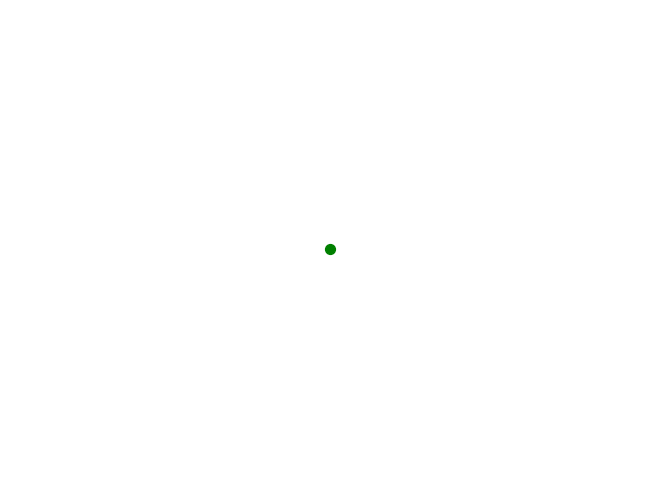

solving ecm alone first time
solved
Constraint Demand_balance
electricity price check model4
electricity_price : Size=8, Index=LoadSet, Domain=Any, Default=0, Mutable=True
    Key              : Value
    (7.0, 2025.0, 1) :       -1784.9688527
    (7.0, 2025.0, 2) :       -1030.4226262
    (7.0, 2025.0, 3) : -2126.4431678023666
    (7.0, 2025.0, 4) :    -1468.8457704643
    (7.0, 2026.0, 1) :       -1694.6675086
    (7.0, 2026.0, 2) :        -979.9139979
    (7.0, 2026.0, 3) : -2044.6662930918667
    (7.0, 2026.0, 4) : -1399.2453562747999
tolerance
1
Iteration
0
building h2 model
test
integrated
integrated
solving h2 model
h2 solved
H2 profit run by itself
Constraint first_block.demand_constraint
building and adding ecm
creating new objective
(type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
MultiBlock with a new Component (type=<class
'pyomo.core.base.constraint.IndexedConstraint'>). This is usually indicative
of a modelling error. To avoid this warning, use block

In [ ]:
##########################################################################################################################################################
##########################################################################################################################################################
# SINGLE OPTIMIZATION WITH ECM AND H2
##########################################################################################################################################################
##########################################################################################################################################################

############################################################################################################################################################
# IMPORT ALL MODULES
############################################################################################################################################################

start_so_total = time.time()
#import in H2 module and declare overall grid 
import regions_integrated2
grid = regions_integrated2.Grid(regions_integrated2.Data())
grid.build_grid()

# import in residential module
model_res = residentialModule()

############################################################################################################################################################
# SET UP PARENT BLOCK STRUCTURE
############################################################################################################################################################

#declare parent block that H2, electricity, and residential child blocks will run under
model3 = pyo.ConcreteModel(name='MultiBlock')
model3.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
#import in data for declaring the region and year size of the models
test_years = list(pd.read_csv(PROJECT_ROOT / 'src/models/electricity/input/sw_year.csv').dropna()['year'])
test_regions = list(pd.read_csv(PROJECT_ROOT / 'src/models/electricity/input/sw_reg.csv').dropna()['region'])
#call preprocessor for creating all sets needed as inputs in electricity model
all_frames, setin = prep.preprocessor(prep.Sets(test_years,test_regions), (PROJECT_ROOT / 'src/models/electricity/input/temp/'))

# declare parent block sets
model3.year = pyo.Set(initialize = setin.y)
model3.regions = pyo.Set(initialize = setin.r)
model3.hr = pyo.Set(initialize = setin.hr)

#Create sparse index sets used by electricity model
def create_subsets(df,col,subset):
    """
    Create subsets of csvs used as input data for teh electricity model

    Args:
        df : data frame
            Name of data frame or csv 
        col : string
            Name of column want data pulled from
        subset : string
            Name of subset

    Returns:
        df : data frame
            subsetted data frame
    """
    df = df[df[col].isin(subset)].dropna()
    return df

def create_hourly_sets(df):
    """
    Create hourly subset of data frame

    Args:
        df : data frame
            Name of data frame

    Returns:
        df : data frame
            New subsetted data frame
    """
    df = pd.merge(df,
                all_frames['Map_hr_s'].reset_index(),
                on=['s'], how='left').drop(columns=['s'])
    return df

index_list = ['pt','y','r','steps','hr'] 

model3.GenSet = pyo.Set(
    initialize = create_hourly_sets(
        create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setin.ptg))
    .set_index(index_list).index
    )

# declare functions that convert electricity generation indexed by year, region, step, hour to weighted generation indexed by year and region 
def get_h2_generation(instance):   # for H2 model electricity price
    """
    Get generation data from electricity model

    Args:
        instance : model class
            an instance of a model (electricity model)

    Returns:
        Generation : pd data frame
        H2 Generation
    """
    Generation =pd.Series(instance.Generation.get_values()).to_frame().reset_index().rename( columns={'level_0':'pt', 'level_1':'y', 'level_2':'r', 'level_3':'steps', 'level_4':'hr', 0:'Generation'})            
    Generation = Generation[Generation['pt'] == 5].drop(columns=['pt','steps'])            
    return Generation        

def sum_annual(instance, df): 
    """
    Convert generation data to be summed across year using hour and day weights

    Args:
        instance : model class
            an instance of a model (electricity model)
        df : pd data fram
            data frame of generation values indexed by year, region, step, hour

    Returns:
        df3 : pd data frame
        H2 Generation indexed by year, region
    """         
    daywt = pd.Series(instance.Dayweights.extract_values()).to_frame().reset_index().rename(columns={'index':'hr', 0:'daywt'})            
    df2 = pd.merge(df, daywt, on='hr',how='outer')            
    df2.loc[:,'Generation'] = df2['Generation'] * df2['daywt']            
    df2.drop(columns = ['hr','daywt'], inplace=True)            
    #df3 = df2.groupby(['y','r']).agg('sum')
    df3 = df2.groupby(['y','r']).agg('sum').reset_index().set_index(['y','r'])           
    return df3  

############################################################################################################################################################
# CREATE MUTABLE PARAMETERS AND THEIR CORRESPONDING SETS THAT GET PASSED BETWEEN EACH MODULE
############################################################################################################################################################

# generate sets and params to pass into electricity model
model3.H2PriceSet = pyo.Set(initialize = all_frames['H2Price'].index)
model3.H2Price = pyo.Param(model3.H2PriceSet, initialize=all_frames['H2Price'], default = 0) #eventually connect with H2 model

# generate sets and params to pass into H2 model
model3.SupplyPriceSet = pyo.Set(initialize = all_frames['SupplyPrice'].index)
model3.H2_electricity_price = pyo.Param(model3.regions,model3.year, mutable = True, default = 0)
model3.H2_DemandSet = pyo.Set(initialize=model3.regions*model3.year)
model3.H2_Demand = pyo.Param(model3.regions,model3.year, mutable = True, default = 0)

#generate sets and params to pass into residential model
model3.LoadSet = pyo.Set(initialize = all_frames['Load'].index)
model3.Load = pyo.Param(model3.LoadSet, initialize = all_frames['Load'], default = 0, mutable=True)
model3.electricity_price = pyo.Param(model3.LoadSet, initialize = all_frames['Load'], default = 0, mutable=True)

model3.SupplyCurveSet = pyo.Set(initialize = all_frames['SupplyCurve'].index)

############################################################################################################################################################
# CREATE AN INSTANCE OF ELECTRICITY MODEL TO INITIALIZE ELECTRICITY PRICES AND H2 DEMAND TO PASS INTO OTHER MODULES
############################################################################################################################################################

# create and solve one instance of the electricity model
print("solving ecm alone first time")
model4 = ECMModel_price_load(all_frames, setin, model3.H2Price, model3.H2PriceSet, model3.Load, model3.LoadSet, sense=pyo.minimize, as_block=False)
model4.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
#solve electricity model by itself 
if setin.sw_learning==1:
    pyo.SolverFactory("appsi_highs").solve(model4)
else:
    pyo.SolverFactory("ipopt").solve(model4)
print("solved")

# pull dual values from the demand balance constraint to get electricity prices to pass into residential model and h2 model
for c in model4.component_objects(pyo.Constraint, active=True):
    const = str(c)
    if const=="Demand_balance":
          print("Constraint", const)
          vars()[const] = pd.DataFrame({'Constraint':[np.nan], 'Index':[0], 'Dual':[0] })
          for index in c:
              last_row =  pd.DataFrame({'Constraint':[const], 'Index':[index], 'Dual':[float(model4.dual[c[index]])] })
              vars()[const] = pd.concat([vars()[const],last_row]).dropna()
    
          vars()[const].reset_index(drop=True, inplace=True)
          df = pd.DataFrame([pd.Series(x) for x in vars()[const]['Index']])
          #Note: I'd like to be able to add the names of the indices automatically, but just using this shortcut for now
          df.columns = ['i_{}'.format(x+1) for x in df.columns]
          vars()[const] = pd.concat([vars()[const], df], axis=1)
          elec_price = vars()[const]

# assign dual values to their respective mutable parameter
for (r,y,hr) in model3.LoadSet:
    reg = int(r)
    hr2 = int(hr)
    yr = int(y)
    model3.H2_electricity_price[reg, yr].value = -model4.dual[model4.Demand_balance[reg, yr, 1]]
    model3.electricity_price[reg, yr, hr].value = -model4.dual[model4.Demand_balance[reg, yr, hr]]
print("electricity price check model4")
model3.electricity_price.pprint()
# convert generation to weighted generation by year and region
h2gen_model4 = get_h2_generation(model4)        
h2gen_ann_model4 = sum_annual(model4, h2gen_model4)

# assign weighted h2 generation to the h2 mutable parameter
dummy_elec = 0

for (tech,year,reg,step,hour) in model4.GenSet:
    r = int(reg)
    steps= int(step)
    yr = int(y)
    hr = int(hour)
    tch = int(tech)
    if (yr,r) in h2gen_ann_model4.index:
        val = h2gen_ann_model4['Generation'].loc[(yr, r)]
        model3.H2_Demand[r, yr].value = val

############################################################################################################################################################
# SET UP INTERATION PROCEDURE TO SOLVE SINGLE OPTIMIZATION 
############################################################################################################################################################

#initialize tolerance and iteration numbers for printing
tol = 1
iter_number = 0

while tol>0.001:

    print("tolerance")
    print(tol)
    print("Iteration")
    print(iter_number)

    ############################################################################################################################################################
    # GENERATE FIRST CHILD BLOCK OF H2 MODEL
    ############################################################################################################################################################

    # create a model instance that takes the grid as input, runs in integrated mode and takes demand and electricity_price as inputs. 
    print("building h2 model")
    model = regions_integrated2.Model(grid, mode = 'integrated', demand = model3.H2_Demand, electricity_price = model3.H2_electricity_price)
    # start_build builds a pyomo block and returns it as a value saved as copied_model
    copied_model = model.start_build()
    # attach the block copied_model to parent block
    model3.first_block = copied_model

    # pull objective function from h2 model
    def total_profit_rule(model3):
        """
        Assign new objective expression for parent block of only H2 production costs

        Args:
            model3 :    model / block class
                parent block

        Returns:
            model3.first_block.production_cost : pyomo expression
                objective expression for parent block of H2 production costs
        """
        return model3.first_block.production_cost
    model3.total_profit = pyo.Objective(rule=total_profit_rule, sense=pyo.minimize)
    # solve only for h2 model
    print("solving h2 model")
    pyo.SolverFactory("appsi_highs").solve(model3)
    print("h2 solved")
    #save inidividual H2 costs
    h2_profit_alone = model3.total_profit()
    print("H2 profit run by itself")

    
    # pull dual values from the demand constraint to get values for H2 prices to pass into electricity model
    for c in model3.component_objects(pyo.Constraint, active=True):
      const = str(c)
      if const=="first_block.demand_constraint":
          print("Constraint", const)
          vars()[const] = pd.DataFrame({'Constraint':[np.nan], 'Index':[0], 'Dual':[0] })
          for index in c:
              last_row =  pd.DataFrame({'Constraint':[const], 'Index':[index], 'Dual':[float(model3.dual[c[index]])] })
              vars()[const] = pd.concat([vars()[const],last_row]).dropna()
    
          vars()[const].reset_index(drop=True, inplace=True)
          df = pd.DataFrame([pd.Series(x) for x in vars()[const]['Index']])
          #Note: I'd like to be able to add the names of the indices automatically, but just using this shortcut for now
          df.columns = ['i_{}'.format(x+1) for x in df.columns]
          vars()[const] = pd.concat([vars()[const], df], axis=1)
          elec_price = vars()[const]

  # assign the H2 price mutable parameter as dual values coming from constraint 
    for (reg, s, pt, step, y) in model3.H2PriceSet:
        if pt==5:
            r = int(reg)
            steps= int(step)
            yr = int(y)
            s2 = int(s)
            #r	s	pt	steps	y
            model3.H2Price[r, s2, 5, step, yr].value = -model3.dual[model3.first_block.demand_constraint[r, yr]]


    # delete objective function to build the rest of the block structure
    model3.del_component(model3.total_profit)
  
    ############################################################################################################################################################
    # GENERATE NEXT CHILD BLOCK OF RESIDENTIAL MODEL
    ############################################################################################################################################################

    # create a model instance 
    model_res = residentialModule()
    # make_block builds a pyomo block and returns it as a value saved as copied_model. takes in electricity price parameter and the parameter index set as inputs
    copied_model = model_res.make_block(model3.electricity_price, model3.LoadSet)
    # assign copied model to the parent block structure
    model3.third_block = copied_model

    ############################################################################################################################################################
    # GENERATE FINAL CHILD BLOCK OF ELECTRICITY MODEL
    ############################################################################################################################################################

    print("building and adding ecm")
    #create model instance that takes as inputs preprocessed csvs and the mutable params H2Price and Load along with their respective indexed sets
    model3.second_block = ECMModel_price_load(all_frames, setin, model3.H2Price, model3.H2PriceSet, model3.Load, model3.LoadSet, sense=pyo.minimize, as_block=True)

    #create new objective summing both the objective function costs from electricity and hydrogen
    print("creating new objective")
    def total_profit_rule(model3):
        """
        Create new objective expression for parent block summing electricity and H2 production costs

        Args:
            model3 :    model / block class
                parent block

        Returns:
            model3.first_block.production_cost + model3.second_block.totalCost: pyomo expression
                objective expression for parent block summing electricity and H2 production costs
        """
        return model3.first_block.production_cost + model3.second_block.totalCost
    model3.total_profit = pyo.Objective(rule=total_profit_rule, sense=pyo.minimize)


    ############################################################################################################################################################
    # GENERATE CONSTRAINTS ON THE FULL PARENT MODEL
    ############################################################################################################################################################
    
    # call functions to convert hydrogen generation to be indexed by year and region
    h2gen_model3 = get_h2_generation(model3.second_block)        
    h2gen_ann_model3 = sum_annual(model3.second_block, h2gen_model3)       

    def get_h2_generation2(instance):
        """
        Preserve electricity generation as a parameter and collapse H2 generation to be summed up annually using day weights

        Args:
            instance : model class
                instance of electricity generation model

        Returns:
            df : data frame
                 data frame of H2 generation indexed by year and region
        """
        # for H2 model electricity price
        df = {}
        for (tech,y,r,step,h) in instance.GenSet:
            if tech == 5:
                if (y,r) not in df:
                        df[(y,r)] = 0
                df[(y,r)] += instance.Generation[(tech,y,r,step,h)] * instance.Dayweights[(h)] * setin.H2_heatrate
        return df
    h2gen_ann2 = get_h2_generation2(model3.second_block)
 
    # create new constraint that assigns the value of mutable parameter of h2 demand to be exactly the h2 generation from the electricity model
    @model3.Constraint(model3.H2_DemandSet)
    def con_expr_rule2(model3, reg, year):
        """
        Generate additional constraint on parent block such that the mutable parameter of H2 demand used as an input in H2 model equals the amount of H2 electricity generated from the electricity model

        Args:
            model3 : block class
                parent block
            reg : index 
                region index
            year : index 
                year index

        Returns:
            Constraint : pyomo constraint
                H2 demand equals the annual H2 generation from electricity model
        """
        r = int(reg)
        yr = int(year)
        return  model3.H2_Demand[r, yr].value == h2gen_ann2[(yr, r)]  
    
    @model3.Constraint(model3.LoadSet)
    def con_expr_rule2(model3, reg,yr,hour):
        """
        Generate additional constraint on parent block such that the mutable parameter of Load used as an input in electricity model is greater than or equal to the amount of residential load generated from the residential model

        Args:
            model3 : block class
                parent block
            reg : index 
                region index
            year : index 
                year index
            hour : index 
                hour index

        Returns:
            Constraint : pyomo constraint
                Load equals the load generated from residential model
        """
        r = int(reg)
        y = int(yr)
        hr = int(hour)
        return  model3.Load[r,y,hr]() >= model3.third_block.Load[r,y,hr]
    
    ############################################################################################################################################################
    # SOLVE FULL SINGLE OPTIMIZATION PROBLEM
    ############################################################################################################################################################
    print("solving full model")
    start_so_solve = time.time() #track solve time

    if setin.sw_learning == 2:  # nonlinear solver
        solver_name = 'ipopt'
        opt = pyo.SolverFactory(solver_name, tee=True)  # , tee=True
        # Select options. The prefix "OF_" tells pyomo to create an options file
        opt.options['OF_mu_strategy'] = 'adaptive'
        opt.options['OF_num_linear_variables'] = 100000
        opt.options['OF_mehrotra_algorithm'] = 'yes'
        # Ask IPOPT to print options so you can confirm that they were used by the solver
        opt.options['print_user_options'] = 'yes'
    else:  # linear solver
        solver_name = 'appsi_highs'
        opt = pyo.SolverFactory(solver_name)

    
    if setin.sw_learning == 1:  # run iterative learning
        # Set any high tolerance
        tol = 999
        iter_num = 0

        def init_old_cap(model3, setin):
            """
            Intialize old capacity level

            ### Args:
                - model3 : model class
                    electricity model instance
                - setin : data frame
                    preprocessed data sets
            """
            model3.second_block.old_cap = {}
            model3.second_block.cap_set = []
            model3.second_block.old_cap_wt = {}

            for r, pt, y, steps in model3.second_block.CapCostSet:
                if (pt, y) not in model3.second_block.old_cap:
                    model3.second_block.cap_set.append((pt, y))
                    # each pt will increase cap by 1 GW per year. reasonable starting point.
                    model3.second_block.old_cap[(pt, y)] = (y - setin.start_year) * 1
                    model3.second_block.old_cap_wt[(pt, y)] = (
                        model3.second_block.year_weights[y] * model3.second_block.old_cap[(pt, y)]
                    )

        def set_new_cap(model3, setin):
            """
            Set new capacity level

            ### Args:
                - model3 : model class
                    electricity model instance
                - setin : data frame
                    preprocessed data sets
            """
            model3.second_block.new_cap = {}
            model3.second_block.new_cap_wt = {}
            for r, pt, y, steps in model3.second_block.CapCostSet:
                if (pt, y) not in model3.second_block.new_cap:
                    model3.second_block.new_cap[(pt, y)] = 0.0
                model3.second_block.new_cap[(pt, y)] = model3.second_block.new_cap[(pt, y)] + sum(
                    model3.second_block.CapacityBuilds[(r, pt, year, steps)].value
                    for year in setin.y
                    if year < y
                )
                model3.second_block.new_cap_wt[(pt, y)] = model3.second_block.year_weights[y] * model3.second_block.new_cap[(pt, y)]

        def cost_learning_func(model3, start_year, pt, y):
            """
            ## Create costs with learning

            ### Args:
                - model3 : model class
                    instance of electricity model
                - start_year : int
                    starting year
                - pt : value
                    technology number(s)
                - y : index set
                    set of years

            ### Returns:
                - cost : 
                    new costs
            """
            cost = (
                (
                    model3.second_block.SupplyCurve_learning[pt]
                    + 0.0001 * (y - start_year)
                    + model3.second_block.new_cap[pt, y]
                )
                / model3.second_block.SupplyCurve_learning[pt]
            ) ** (-1.0 * model3.second_block.LearningRate[pt])
            return cost

        def update_cost(model3, setin):
            """
            Set new costs level

            ### Args:
                - model3 : model class
                    electricity model instance
                - setin : data frame
                    preprocessed data sets
            """
            new_multiplier = {}
            for pt, y in model3.second_block.cap_set:
                new_multiplier[(pt, y)] = cost_learning_func(model3, setin.start_year, pt, y)

            new_cost = {}
            # Assign new learning
            for r, pt, y, steps in model3.second_block.CapCostSet:
                # updating learning cost
                new_cost[(r, pt, y, steps)] = (
                    model3.second_block.CapCost_y0[(r, pt, steps)] * new_multiplier[pt, y]
                )
                model3.second_block.capacity_costs_learning[(r, pt, y, steps)].value = new_cost[
                    (r, pt, y, steps)
                ]

        # initialize capacity to set pricing
        init_old_cap(model3.second_block, setin)
        model3.second_block.new_cap = model3.second_block.old_cap
        update_cost(model3.second_block, setin)

    # solve modules
    opt.solve(model3, tee=True)
    
    
    end_so_solve = time.time()
    time_so_solve = end_so_solve - start_so_solve     
    print("solved")
    



    ############################################################################################################################################
    ### UPDATE LOOP AND CHECK TOLERANCE LEVELS 
    ############################################################################################################################################

    #pull new dual values from the electricity model to check tolerance
    for c in model3.component_objects(pyo.Constraint, active=True):
        const = str(c)
        if const=="second_block.Demand_balance":
            print("Constraint", const)
            vars()[const] = pd.DataFrame({'Constraint':[np.nan], 'Index':[0], 'Dual':[0] })
            for index in c:
                last_row =  pd.DataFrame({'Constraint':[const], 'Index':[index], 'Dual':[float(model3.dual[c[index]])] })
                vars()[const] = pd.concat([vars()[const],last_row]).dropna()
        
            vars()[const].reset_index(drop=True, inplace=True)
            df = pd.DataFrame([pd.Series(x) for x in vars()[const]['Index']])
            #Note: I'd like to be able to add the names of the indices automatically, but just using this shortcut for now
            df.columns = ['i_{}'.format(x+1) for x in df.columns]
            vars()[const] = pd.concat([vars()[const], df], axis=1)
            elec_price = vars()[const]


    print("checking tolerance")
    iter_number += 1
    tol = 0

    #check tolerance by:
    #checking the difference in the assigned mutable parameters for electricity price before the single optimization solve and after the single optimization solve to  ensure they are consistent
    for (r,y,hr) in model3.LoadSet:
        reg = int(r)
        hr2 = int(hr)
        yr = int(y)
        tol += abs(model3.H2_electricity_price[reg, yr].value + model3.dual[model3.second_block.Demand_balance[reg, yr, 1]])
        tol+= abs(model3.electricity_price[reg, yr, hr].value + model3.dual[model3.second_block.Demand_balance[reg, yr, hr]])
    #check the difference for the duals values on H2 price
    for (reg, s, pt, step, y) in model3.H2PriceSet:
        if pt==5:
            r = int(reg)
            steps= int(step)
            yr = int(y)
            s2 = int(s)
            tol += abs(model3.H2Price[r, s2, 5, steps, yr].value + model3.dual[model3.first_block.demand_constraint[5, yr, r, steps, hr]])
    
    print(tol)

    ############################################################################################################################################
    ### CHECK TOLERANCE - IF NEED ANOTHER RUN, THEN UPDATE PARAMETER VALUES AND DELETE BLOCK COMPONENTS
    ############################################################################################################################################
            # assign mutable parameters for electricity price to the newly updated dual values from the electricity model
    for (r,y,hr) in model3.LoadSet:
            reg = int(r)
            hr2 = int(hr)
            yr = int(y)
            model3.H2_electricity_price[reg, yr].value = -model3.dual[model3.second_block.Demand_balance[reg, yr, 1]]
            model3.electricity_price[reg, yr, hr].value = -model3.dual[model3.second_block.Demand_balance[reg, yr, hr]]
        # convert generation to be indexed by year and region
    h2gen_model3 = get_h2_generation(model3.second_block)        
    h2gen_ann_model3 = sum_annual(model3.second_block, h2gen_model3)
        # assign H2 demand to the newly updated electricity generation values
    
    for (tech,year,reg,step,hour) in model3.GenSet:
            r = int(reg)
            steps= int(step)
            yr = int(y)
            hr = int(hour)
            tch = int(tech)
            if (yr,r) in h2gen_ann_model4.index:
                val = h2gen_ann_model3['Generation'].loc[(yr, r)]
                model3.H2_Demand[r, yr].value = val

    if tol>0.001:

        
        #delete all block components - child blocks, objective functions, constraint, and constraint index
        model3.del_component(model3.total_profit)
        model3.del_component(model3.Constraint)
        #model3.del_component(model3.Constraint_index)
        model3.del_component(model3.first_block)
        model3.del_component(model3.second_block)
        model3.del_component(model3.third_block)
        



############################################################################################################################################
### POST-PROCESSING - CHECK MODEL OBJECTIVE FUNCTION AND RUN TIMES
############################################################################################################################################
h2_merged_so = 0
elec_merged_so = 0
#calculate total electricity generated
for (tech, hour, reg, step, year) in model3.GenSet:
    r = int(reg)
    steps= int(step)
    yr = int(year)
    hr = int(hour)
    tch = int(tech)
    elec_merged_so += model3.second_block.Generation[tch, hr, r, steps, yr]()
#calculate total h2 generated
for (reg, year) in model3.H2_DemandSet:
    r = int(reg)
    yr = int(year)
    h2_merged_so += model3.H2_Demand[r, yr]()
#calculate total costs
profit_so = model3.total_profit()

end_so_total = time.time() #track total time
time_so_total = start_so_total-end_so_total

print("H2 supplied")
print(h2_merged_so)
print("Electricity supplied")
print(elec_merged_so)
print("total cost")
print(profit_so)
print("total single op time")
print(time_so_total)


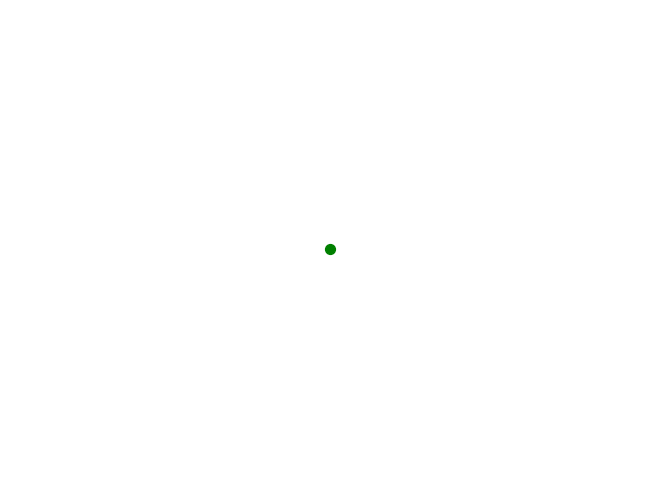

solving ecm alone first time
'pyomo.core.base.set.OrderedScalarSet'>) on block ElectricityModel with a new
Component (type=<class 'pyomo.core.base.set.AbstractOrderedScalarSet'>). This
is usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
solved
Constraint Demand_balance
tolerance
1
Iteration
0
building h2 model
test
integrated
integrated
solving h2 model
h2 solved
Constraint first_block.demand_constraint
building and adding residential
building and adding ecm
creating new objective
solving electricity model
solved
pulling vars to update h2
Constraint second_block.Demand_balance
H2 supplied
0
Electricity supplied
3908.8856059001137
792027.2434928673
tolerance
792027.2434928673
Iteration
1
building h2 model
test
integrated
integrated
solving h2 model
h2 solved
Constraint first_block.demand_constraint
building and adding residential
'pyomo.core.base.block.ScalarBlock'>) on block ECMBlock with a new Component
(type=<class '

In [ ]:
##########################################################################################################################################################
##########################################################################################################################################################
# GAUSS SEIDEL WITH ECM AND H2 AND RESIDENTIAL
##########################################################################################################################################################
##########################################################################################################################################################


############################################################################################################################################################
# IMPORT ALL MODULES
############################################################################################################################################################

start_gs_total = time.time() #start tracking total time

#import in H2 module and declare overall grid 
import regions_integrated2
grid = regions_integrated2.Grid(regions_integrated2.Data())
grid.build_grid()

#call preprocessor for creating all sets needed as inputs in electricity model
#import in data for declaring the region and year size of the models
test_years = list(pd.read_csv(PROJECT_ROOT / 'src/models/electricity/input/sw_year.csv').dropna()['year'])
test_regions = list(pd.read_csv(PROJECT_ROOT / 'src/models/electricity/input/sw_reg.csv').dropna()['region'])
#call preprocessor for creating all sets needed as inputs in electricity model
all_frames, setin = prep.preprocessor(prep.Sets(test_years,test_regions), (PROJECT_ROOT / 'src/models/electricity/input/temp/'))

############################################################################################################################################################
# CREATE BLOCK STRUCTURE FOR ALL ITERATING MODELS - H2, ELECTRICITY, AND RESIDENTIAL
# INCLUDE BLOCKS AND SETS AND PARAMTERS
############################################################################################################################################################

# declare block for H2 model
model1 = pyo.ConcreteModel(name='H2Block')
model1.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
#initialize sets
model1.year = pyo.Set(initialize = setin.y)
model1.regions = pyo.Set(initialize = setin.r)
model1.hr = pyo.Set(initialize = setin.hr)

#intialize all mutable parameters and their sets that get passed between all modules
# params to pass into ECM
model1.H2PriceSet = pyo.Set(initialize = all_frames['H2Price'].index)
model1.H2Price = pyo.Param(model3.H2PriceSet, initialize=all_frames['H2Price'], default = 0) #eventually connect with H2 model
# params to pass into h2
model1.SupplyPriceSet = pyo.Set(initialize = all_frames['SupplyPrice'].index)
model1.H2_electricity_price = pyo.Param(model3.regions,model3.year, mutable = True, default = 0)
model1.H2_DemandSet = pyo.Set(initialize=model1.regions*model1.year)
model1.H2_Demand = pyo.Param(model3.regions,model3.year, mutable = True, default = 0)
#params to pass into residential
model1.LoadSet = pyo.Set(initialize = all_frames['Load'].index)
model1.Load = pyo.Param(model1.LoadSet, initialize = all_frames['Load'], default = 0, mutable=True)
model1.electricity_price = pyo.Param(model1.LoadSet, initialize = all_frames['Load'], default = 0, mutable=True)
model1.SupplyCurveSet = pyo.Set(initialize = all_frames['SupplyCurve'].index)

# declare block for electricity model
model3 = pyo.ConcreteModel(name='ECMBlock')
model3.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
#initialize sets
model3.year = pyo.Set(initialize = setin.y)
model3.regions = pyo.Set(initialize = setin.r)
model3.hr = pyo.Set(initialize = setin.hr)

#intialize all mutable parameters and their sets that get passed between all modules
# params to pass into ECM
model3.H2PriceSet = pyo.Set(initialize = all_frames['H2Price'].index)
model3.H2Price = pyo.Param(model3.H2PriceSet, initialize=all_frames['H2Price'], default = 0) #eventually connect with H2 model
# params to pass into h2
#model3.GenSet = pyo.Set(initialize = all_frames['GenSet'].index)
model3.SupplyPriceSet = pyo.Set(initialize = all_frames['SupplyPrice'].index)
model3.H2_electricity_price = pyo.Param(model3.regions,model3.year, mutable = True, default = 0)
model3.H2_DemandSet = pyo.Set(initialize=model3.regions*model3.year)
model3.H2_Demand = pyo.Param(model3.regions,model3.year, mutable = True, default = 0)
#params to pass into residential
model3.LoadSet = pyo.Set(initialize = all_frames['Load'].index)
model3.Load = pyo.Param(model3.LoadSet, initialize = all_frames['Load'], default = 0, mutable=True)
model3.electricity_price = pyo.Param(model3.LoadSet, initialize = all_frames['Load'], default = 0, mutable=True)
model3.SupplyCurveSet = pyo.Set(initialize = all_frames['SupplyCurve'].index)


#Create sparse index sets used by electricity model
def create_subsets(df,col,subset):
    """
    Create subsets of csvs used as input data for teh electricity model

    Args:
        df : data frame
            Name of data frame or csv 
        col : string
            Name of column want data pulled from
        subset : string
            Name of subset

    Returns:
        df : data frame
            subsetted data frame
    """
    df = df[df[col].isin(subset)].dropna()
    return df

def create_hourly_sets(df):
    """
    Create hourly subset of data frame

    Args:
        df : data frame
            Name of data frame

    Returns:
        df : data frame
            New subsetted data frame
    """
    df = pd.merge(df,
                all_frames['Map_hr_s'].reset_index(),
                on=['s'], how='left').drop(columns=['s'])
    return df

index_list = ['pt','y','r','steps','hr'] 

# create a gen set to be assigned to both H2 and electricity model
model1.GenSet = pyo.Set(
    initialize = create_hourly_sets(
        create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setin.ptg))
    .set_index(index_list).index
    )

model3.GenSet = pyo.Set(
    initialize = create_hourly_sets(
        create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setin.ptg))
    .set_index(index_list).index
    )

# declare functions that convert electricity generation indexed by year, region, step, hour to weighted generation indexed by year and region 
def get_h2_generation(instance):   # for H2 model electricity price
    """
    Get generation data from electricity model

    Args:
        instance : model class
            an instance of a model (electricity model)

    Returns:
        Generation : pd data frame
        H2 Generation
    """
    Generation =pd.Series(instance.Generation.get_values()).to_frame().reset_index().rename( columns={'level_0':'pt', 'level_1':'y', 'level_2':'r', 'level_3':'steps', 'level_4':'hr', 0:'Generation'})            
    Generation = Generation[Generation['pt'] == 5].drop(columns=['pt','steps'])            
    return Generation        

def sum_annual(instance, df):      
    """
    Convert generation data to be summed across year using hour and day weights

    Args:
        instance : model class
            an instance of a model (electricity model)
        df : pd data fram
            data frame of generation values indexed by year, region, step, hour

    Returns:
        df3 : pd data frame
        H2 Generation indexed by year, region
    """       
    daywt = pd.Series(instance.Dayweights.extract_values()).to_frame().reset_index().rename(columns={'index':'hr', 0:'daywt'})            
    df2 = pd.merge(df, daywt, on='hr',how='outer')            
    df2.loc[:,'Generation'] = df2['Generation'] * df2['daywt']            
    df2.drop(columns = ['hr','daywt'], inplace=True)            
    #df3 = df2.groupby(['y','r']).agg('sum')
    df3 = df2.groupby(['y','r']).agg('sum').reset_index().set_index(['y','r'])           
    return df3   

############################################################################################################################################################
# CREATE AN INSTANCE OF ELECTRICITY MODEL TO INITIALIZE ELECTRICITY PRICES AND H2 DEMAND TO PASS INTO OTHER MODULES
############################################################################################################################################################
# create and solve one instance of the electricity model
print("solving ecm alone first time")
model4 = ECMModel_price_load(all_frames, setin, model3.H2Price, model3.H2PriceSet, model3.Load, model3.LoadSet, sense=pyo.minimize, as_block=False)
#create an index set for generation
model4.GenSet = pyo.Set(
    initialize = create_hourly_sets(
        create_subsets(all_frames['SupplyCurve'].reset_index(),'pt',setin.ptg))
    .set_index(index_list).index
    )
model4.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
if setin.sw_learning==1:
    pyo.SolverFactory("appsi_highs").solve(model4)
else:
    pyo.SolverFactory("ipopt").solve(model4)
print("solved")

# pull dual values from the demand balance constraint to get electricity prices to pass into residential model and h2 model
for c in model4.component_objects(pyo.Constraint, active=True):
    const = str(c)
    if const=="Demand_balance":
          print("Constraint", const)
          vars()[const] = pd.DataFrame({'Constraint':[np.nan], 'Index':[0], 'Dual':[0] })
          for index in c:
              last_row =  pd.DataFrame({'Constraint':[const], 'Index':[index], 'Dual':[float(model4.dual[c[index]])] })
              vars()[const] = pd.concat([vars()[const],last_row]).dropna()
    
          vars()[const].reset_index(drop=True, inplace=True)
          df = pd.DataFrame([pd.Series(x) for x in vars()[const]['Index']])
          #Note: I'd like to be able to add the names of the indices automatically, but just using this shortcut for now
          df.columns = ['i_{}'.format(x+1) for x in df.columns]
          vars()[const] = pd.concat([vars()[const], df], axis=1)
          elec_price = vars()[const]

# assign dual values to their respective mutable parameter in both the residential and H2 models
for (r,y,hr) in model3.LoadSet:
    reg = int(r)
    hr2 = int(hr)
    yr = int(y)
    model1.H2_electricity_price[reg, yr].value = -model4.dual[model4.Demand_balance[reg, yr, 1]]
    model3.electricity_price[reg, yr, hr].value = -model4.dual[model4.Demand_balance[reg, yr, hr]]

# convert generation to weighted generation by year and region
h2gen_model4 = get_h2_generation(model4)        
h2gen_ann_model4 = sum_annual(model4, h2gen_model4)

# assign weighted h2 generation to the h2 mutable parameter

for (tech,year,reg,step,hour) in model4.GenSet:
    r = int(reg)
    steps= int(step)
    yr = int(y)
    hr = int(hour)
    tch = int(tech)
    if (yr,r) in h2gen_ann_model4.index:
        val = h2gen_ann_model4['Generation'].loc[(yr, r)]
        model1.H2_Demand[r, yr].value = val

#######################################################################################################################################################################
## SET UP ITERATION PROCEDURE 
# INITIAL TOLERANCE AND INTIAL QUANTITIES TO CHECK GS ITERATION CONVERGENCE
#######################################################################################################################################################################
############################################################################################################################################################
# SET UP INTERATION PROCEDURE TO SOLVE GAUSS SEIDEL
############################################################################################################################################################

#generate intial tolerance values and intial quantities andobjective function values to check tolerance later
tol = 1
tol_profit=1
iter_number = 0
# vals for checking h2 and electricity quantities later
totaleq_t1 = 0 # electricity
totalhq_t1 = 0 # h2
# vals for checking objective functions later
totaleo_t1 = 1 # electricity
totalho_t1 = 1 # h2


#start_gs = time.time()  
tol_value = 0.0001
tol_profit_value = 0.0001

while tol>0.0001:
    print("tolerance")
    print(tol)
    print("Iteration")
    print(iter_number)

    ############################################################################################################################################################
    # GENERATE FIRST MODEL OF H2 MODEL
    ############################################################################################################################################################
    
    # create a model instance that takes the grid as input, runs in integrated mode and takes demand and electricity_price as inputs. 
    print("building h2 model")
    model = regions_integrated2.Model(grid, mode = 'integrated', demand = model1.H2_Demand, electricity_price = model1.H2_electricity_price)
    # start_build builds a pyomo block and returns it as a value saved as copied_model
    copied_model = model.start_build()
    # attach the block copied_model to parent block
    model1.first_block = copied_model

     # pull objective function from h2 model
    def total_profit_rule(model1):
        """
        Assign new objective expression for parent block of only H2 production costs

        Args:
            model1 :    model / block class
                parent block

        Returns:
            model1.first_block.production_cost : pyomo expression
                objective expression for parent block of H2 production costs
        """
        return model1.first_block.production_cost
    model1.total_profit = pyo.Objective(rule=total_profit_rule, sense=pyo.minimize)
    # solve only for h2 model
    print("solving h2 model")
    pyo.SolverFactory("appsi_highs").solve(model1)
    print("h2 solved")
    #save inidividual H2 costs
    h2_profit_alone = model1.total_profit()

    # pull dual values from the demand constraint to get values for H2 prices to pass into electricity model
    for c in model1.component_objects(pyo.Constraint, active=True):
      const = str(c)
      if const=="first_block.demand_constraint":
          print("Constraint", const)
          vars()[const] = pd.DataFrame({'Constraint':[np.nan], 'Index':[0], 'Dual':[0] })
          for index in c:
              last_row =  pd.DataFrame({'Constraint':[const], 'Index':[index], 'Dual':[float(model1.dual[c[index]])] })
              vars()[const] = pd.concat([vars()[const],last_row]).dropna()
    
          vars()[const].reset_index(drop=True, inplace=True)
          df = pd.DataFrame([pd.Series(x) for x in vars()[const]['Index']])
          #Note: I'd like to be able to add the names of the indices automatically, but just using this shortcut for now
          df.columns = ['i_{}'.format(x+1) for x in df.columns]
          vars()[const] = pd.concat([vars()[const], df], axis=1)
          elec_price = vars()[const]

    # assign the H2 price mutable parameter as dual values coming from constraint 
    for (reg, s, pt, step, y) in model1.H2PriceSet:
        if pt==5:
            r = int(reg)
            steps= int(step)
            yr = int(y)
            s2 = int(s)
            model3.H2Price[r, s2, 5, step, yr].value = -model1.dual[model1.first_block.demand_constraint[r, yr]]
 
  
    ############################################################################################################################################################
    # GENERATE NEXT MODULE OF RESIDENTIAL MODEL
    ############################################################################################################################################################

    print("building and adding residential")
    # create a model instance 
    model_res = residentialModule()
    # make_block builds a pyomo block and returns it as a value saved as copied_model. takes in electricity price parameter and the parameter index set as inputs
    copied_model = model_res.make_block(model3.electricity_price, model3.LoadSet)
    # assign copied model to the block structure
    model3.third_block = copied_model
    
    # assign mutable parameter of Load as the updated load values from the residential module
    #for (r,y,hr) in model3.LoadSet:
    #    model3.Load[r,y,hr]() == model3.third_block.Load[r,y,hr]()

    ############################################################################################################################################################
    # GENERATE FINAL MODEL OF ELECTRICITY MODEL
    ############################################################################################################################################################
    #create model instance that takes as inputs preprocessed csvs and the mutable params H2Price and Load along with their respective indexed sets
    print("building and adding ecm")
    model3.second_block = ECMModel_price_load(all_frames, setin, model3.H2Price, model3.H2PriceSet, model3.Load, model3.LoadSet, sense=pyo.minimize, as_block=True)

    
    @model3.Constraint(model3.LoadSet)
    def con_expr_rule2(model3, reg,yr,hour):
        """
        Generate additional constraint on parent block such that the mutable parameter of Load used as an input in electricity model is greater than or equal to the amount of residential load generated from the residential model

        Args:
            model3 : block class
                parent block
            reg : index 
                region index
            year : index 
                year index
            hour : index 
                hour index

        Returns:
            Constraint : pyomo constraint
                Load equals the load generated from residential model
        """
        r = int(reg)
        y = int(yr)
        hr = int(hour)
        return  model3.Load[r,y,hr]() >= model3.third_block.Load[r,y,hr]
    

    #create new objective summing both the objective function costs from electricity and hydrogen
    print("creating new objective")
    def total_profit_rule(model3):
        """
        Create new objective expression for parent block of only electricity  production costs

        Args:
            model3 :    model / block class
                parent block

        Returns:
            model3.second_block.totalCost: pyomo expression
                objective expression for parent block for electricity production costs
        """
        return model3.second_block.totalCost
    model3.total_profit = pyo.Objective(rule=total_profit_rule, sense=pyo.minimize)



    if setin.sw_learning == 2:  # nonlinear solver
        solver_name = 'ipopt'
        opt = pyo.SolverFactory(solver_name, tee=True)  # , tee=True
        # Select options. The prefix "OF_" tells pyomo to create an options file
        opt.options['OF_mu_strategy'] = 'adaptive'
        opt.options['OF_num_linear_variables'] = 100000
        opt.options['OF_mehrotra_algorithm'] = 'yes'
        # Ask IPOPT to print options so you can confirm that they were used by the solver
        opt.options['print_user_options'] = 'yes'
    else:  # linear solver
        solver_name = 'appsi_highs'
        opt = pyo.SolverFactory(solver_name)

    
    if setin.sw_learning == 1:  # run iterative learning
        # Set any high tolerance
        tol = 999
        iter_num = 0

        def init_old_cap(model3, setin):
            """
            Intialize old capacity level

            ### Args:
                - model3 : model class
                    electricity model instance
                - setin : data frame
                    preprocessed data sets
            """
            model3.second_block.old_cap = {}
            model3.second_block.cap_set = []
            model3.second_block.old_cap_wt = {}

            for r, pt, y, steps in model3.second_block.CapCostSet:
                if (pt, y) not in model3.second_block.old_cap:
                    model3.second_block.cap_set.append((pt, y))
                    # each pt will increase cap by 1 GW per year. reasonable starting point.
                    model3.second_block.old_cap[(pt, y)] = (y - setin.start_year) * 1
                    model3.second_block.old_cap_wt[(pt, y)] = (
                        model3.second_block.year_weights[y] * model3.second_block.old_cap[(pt, y)]
                    )

        def set_new_cap(model3, setin):
            """
            Set new capacity level

            ### Args:
                - model3 : model class
                    electricity model instance
                - setin : data frame
                    preprocessed data sets
            """
            model3.second_block.new_cap = {}
            model3.second_block.new_cap_wt = {}
            for r, pt, y, steps in model3.second_block.CapCostSet:
                if (pt, y) not in model3.second_block.new_cap:
                    model3.second_block.new_cap[(pt, y)] = 0.0
                model3.second_block.new_cap[(pt, y)] = model3.second_block.new_cap[(pt, y)] + sum(
                    model3.second_block.CapacityBuilds[(r, pt, year, steps)].value
                    for year in setin.y
                    if year < y
                )
                model3.second_block.new_cap_wt[(pt, y)] = model3.second_block.year_weights[y] * model3.second_block.new_cap[(pt, y)]

        def cost_learning_func(model3, start_year, pt, y):
            """
            ## Create costs with learning

            ### Args:
                - model3 : model class
                    instance of electricity model
                - start_year : int
                    starting year
                - pt : value
                    technology number(s)
                - y : index set
                    set of years

            ### Returns:
                - cost : 
                    new costs
            """
            cost = (
                (
                    model3.second_block.SupplyCurve_learning[pt]
                    + 0.0001 * (y - start_year)
                    + model3.second_block.new_cap[pt, y]
                )
                / model3.second_block.SupplyCurve_learning[pt]
            ) ** (-1.0 * model3.second_block.LearningRate[pt])
            return cost

        def update_cost(model3, setin):
            """
            Set new costs level

            ### Args:
                - model3 : model class
                    electricity model instance
                - setin : data frame
                    preprocessed data sets
            """
            new_multiplier = {}
            for pt, y in model3.second_block.cap_set:
                new_multiplier[(pt, y)] = cost_learning_func(model3, setin.start_year, pt, y)

            new_cost = {}
            # Assign new learning
            for r, pt, y, steps in model3.second_block.CapCostSet:
                # updating learning cost
                new_cost[(r, pt, y, steps)] = (
                    model3.second_block.CapCost_y0[(r, pt, steps)] * new_multiplier[pt, y]
                )
                model3.second_block.capacity_costs_learning[(r, pt, y, steps)].value = new_cost[
                    (r, pt, y, steps)
                ]


    # initialize capacity to set pricing
    init_old_cap(model3.second_block, setin)
    model3.second_block.new_cap = model3.second_block.old_cap
    update_cost(model3.second_block, setin)
    # solve electricity model
    print("solving electricity model")
    opt.solve(model3)
    print("solved")

    ############################################################################################################################################
    ### UPDATE LOOP AND CHECK TOLERANCE LEVELS 
    ############################################################################################################################################

    #pull variables to update the H2 model
    print("pulling vars to update h2")

    #convert generation to be indexed by year and region
    h2gen_model3 =  get_h2_generation(model3.second_block)        
    h2gen_ann_model3 = sum_annual(model3.second_block, h2gen_model3)
    # assign H2 demand to the newly updated electricity generation values
    
    for (tech,year,reg,step,hour) in model3.GenSet:
      r = int(reg)
      steps= int(step)
      yr = int(y)
      hr = int(hour)
      tch = int(tech)
      if (yr,r) in h2gen_ann_model4.index:
        val = h2gen_ann_model3['Generation'].loc[(yr, r)]
        model1.H2_Demand[r, yr].value = val

    #pull new dual values from the electricity model to update h2 model
    for c in model3.component_objects(pyo.Constraint, active=True):
        const = str(c)
        if const=="second_block.Demand_balance":
            print("Constraint", const)
            vars()[const] = pd.DataFrame({'Constraint':[np.nan], 'Index':[0], 'Dual':[0] })
            for index in c:
                last_row =  pd.DataFrame({'Constraint':[const], 'Index':[index], 'Dual':[float(model3.dual[c[index]])] })
                vars()[const] = pd.concat([vars()[const],last_row]).dropna()
        
            vars()[const].reset_index(drop=True, inplace=True)
            df = pd.DataFrame([pd.Series(x) for x in vars()[const]['Index']])
            #Note: I'd like to be able to add the names of the indices automatically, but just using this shortcut for now
            df.columns = ['i_{}'.format(x+1) for x in df.columns]
            vars()[const] = pd.concat([vars()[const], df], axis=1)
            elec_price = vars()[const]
    
    # assign mutable parameters for electricity price to the newly updated dual values from the electricity model   
    for (r,y,hr) in model3.LoadSet:
        reg = int(r)
        hr2 = int(hr)
        yr = int(y)
        model1.H2_electricity_price[reg, yr].value = -model3.dual[model3.second_block.Demand_balance[reg, yr, 1]]
        model3.electricity_price[reg, yr, hr].value = -model3.dual[model3.second_block.Demand_balance[reg, yr, hr]]
            

    ############################################################################################################################################
    ### UPDATE LOOP AND CHECK TOLERANCE LEVELS 
    # ENSURE THAT QUANTITIES AND OBJECTIVES ARE CONVERGING THROUGH ITERATIONS
    ############################################################################################################################################

    #assign new starting tol values
    iter_number += 1
    tol = 0
    tol_profit=0

    # create vals to check the quantity of h2 and electricity generated
    h2_merged = 0
    elec_merged = 0
    for (tech, year, reg, step, hour) in model3.SupplyPriceSet:
        elec_merged += model3.second_block.Generation[tch, yr, r, steps, hr]()
    for (reg, year) in model1.H2_DemandSet:
        r = int(reg)
        yr = int(year)
        h2_merged += model3.H2_Demand[r, yr]()

    # check the amount of h2 and electricity supplied for this iteration
    print("H2 supplied")
    print(h2_merged)
    print("Electricity supplied")
    print(elec_merged)

    # check the total costs for h2 and electricity
    h2_profit = model1.total_profit()
    elec_profit = model3.total_profit()
    #check tolerance on if quantities and objective functions are changing over time
    tol += abs((elec_merged - totaleq_t1) + (h2_merged - totalhq_t1)  + (elec_profit - totaleo_t1) + (h2_profit - totalho_t1))
    #check only if objective function values are changing over time
    tol_profit = abs((elec_profit - totaleo_t1) + (h2_profit - totalho_t1))
    print(tol)    
    ############################################################################################################################################
    ### CHECK TOLERANCE - IF NEED ANOTHER RUN, THEN UPDATE OBJECTIVE AND QUANTITY VALUES AND DELETE BLOCK COMPONENTS
    ############################################################################################################################################
    if tol>0.0001:
        model1.del_component(model1.total_profit)
        model3.del_component(model3.total_profit)
        model1.del_component(model1.first_block)
        model3.del_component(model3.second_block)
        totaleq_t1 = elec_merged
        totalhq_t1 = h2_merged
        totaleo_t1 = elec_profit
        totalho_t1 = h2_profit


############################################################################################################################################
### POST - PROCESSING
# CHECK MODEL TIMES, QUANTITY PRODUCED, AND TOTAL PROFITS
############################################################################################################################################
end_gs_total = time.time() #track total time
time_gs_total = start_gs_total-end_gs_total

print("Coal supplied")
print(h2_merged)
print("Electricity supplied")
print(elec_merged)
print("H2 profit")
print(h2_profit)
print("electricity profit")
print(elec_profit)
print("total profit")
total_profit = h2_profit+elec_profit
print(total_profit)
errorpct = (profit_so-total_profit)/total_profit*100
print("percent error")
print(errorpct)

